# Import Libaries

In [1]:
import pandas as pd
import time
from pathlib import Path
from glob import glob
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from ydata_profiling import ProfileReport
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import scipy.cluster.hierarchy as shc
from kneed import KneeLocator
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, train_test_split
from hyperopt import fmin, space_eval, tpe, hp
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
from scipy.sparse import csr_matrix
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
import math
import squarify
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from lazypredict.Supervised import LazyRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score
import shap
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Define Functions 

In [2]:
def treatoutliers(df=None, columns=None, factor=2.0, method='IQR', treament='cap', pct_min = 0.05, pct_max = 0.95):
        
    for column in columns:
        if method == 'STD':
            permissable_std = factor * df[column].std()
            col_mean = df[column].mean()
            floor, ceil = col_mean - permissable_std, col_mean + permissable_std
        elif method == 'IQR':
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            floor, ceil = Q1 - factor * IQR, Q3 + factor * IQR
        elif method == 'PCT':
            floor, ceil = df[column].quantile(pct_min), df[column].quantile(pct_max)
        if treament == 'remove':
            df = df[(df[column] >= floor) & (df[column] <= ceil)]
        elif treament == 'cap':
            df[column] = df[column].clip(floor, ceil)
      
    return df

# Load Data 

## Highlights

<em><strong>==========================================================================================</strong></em>.

1. The data provided to you comes from over 1000 buildings over a two-year timeframe (2016 and 2017). 

2. Buildings are grouped by sites (probably US and a couple foreign University Campus)

3. Have different usage (Education, Parking, Residence...).

4. Measurement data coming from metered building energy usage in the following areas:

       4.1. chilled water
       4.2. electric
       4.3. hot water
       4.4. solar energy
       4.5. irrigation
       4.6. steam meters
       4.7. water
       4.8. gas
       

5. Measurements are collected hourly and represent a signification amount of data that you are free to reduce.

<em><strong>==========================================================================================</strong></em>.

## Adding all datasets

we begin by loading multiple datasets and creating a Pandas DataFrame object for each of them. To generate the object name for each DataFrame, we use a dynamic approach by adding the "df_" prefix to the file name without the ".csv" suffix.

To create the DataFrame objects with these dynamic names, we use the globals() function. This function allows us to create objects with specified names in the global namespace, which enables us to access them outside of the loop. By using this approach, we can create a separate DataFrame object for each file that we load, with names such as df_chilledwater_cleaned, df_electricity_cleaned, and so on.

In [3]:
# Define a list of file names to read
file_names = ['chilledwater_cleaned.csv', 'electricity_cleaned.csv', 'gas_cleaned.csv', 'hotwater_cleaned.csv', 'irrigation_cleaned.csv', 'metadata.csv', 'solar_cleaned.csv', 'steam_cleaned.csv', 'water_cleaned.csv','weather.csv']

# Loop through each file and read it using pandas
for file_name in file_names:
    # Create the object name by adding "df_" prefix and removing ".csv" suffix
    obj_name = "df_" + file_name[:-4]
    
    # Read the file and create the object with the specified name
    globals()[obj_name] = pd.read_csv(file_name)

In [4]:
pd.set_option('display.max_columns', 60) #To display all columns
df_metadata

,building_id,site_id,building_id_kaggle,site_id_kaggle,primaryspaceusage,sub_primaryspaceusage,sqm,sqft,lat,lng,timezone,electricity,hotwater,chilledwater,steam,water,irrigation,solar,gas,industry,subindustry,heatingtype,yearbuilt,date_opened,numberoffloors,occupants,energystarscore,eui,site_eui,source_eui,leed_level,rating
0,Panther_lodging_Dean,Panther,NaN,0.00,Lodging/residential,Residence Hall,508.80,5477.00,28.52,-81.38,US/Eastern,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,1989.00,NaN,NaN,NaN,NaN,271,NaN,NaN,None,NaN
1,Panther_lodging_Shelia,Panther,NaN,0.00,Lodging/residential,Residence Hall,929.00,10000.00,28.52,-81.38,US/Eastern,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,1992.00,NaN,NaN,NaN,NaN,62,NaN,NaN,None,NaN
2,Panther_lodging_Ricky,Panther,NaN,0.00,Lodging/residential,Residence Hall,483.10,5200.00,28.52,-81.38,US/Eastern,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,2016.00,NaN,NaN,NaN,NaN,534,NaN,NaN,None,NaN
3,Panther_education_Rosalie,Panther,0.00,0.00,Education,Research,690.50,7432.00,28.52,-81.38,US/Eastern,Yes,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,2008.00,NaN,NaN,NaN,NaN,276,NaN,NaN,None,NaN
4,Panther_education_Misty,Panther,1.00,0.00,Education,Research,252.70,2720.00,28.52,-81.38,US/Eastern,Yes,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,2004.00,NaN,NaN,NaN,NaN,375,NaN,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,Mouse_health_Estela,Mouse,NaN,NaN,Healthcare,Hospital,17193.00,185064.00,51.52,-0.12,Europe/London,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Healthcare,Hospital,District Heating,1936.00,NaN,10.00,NaN,NaN,NaN,NaN,NaN,NaN,F
1632,Mouse_health_Ileana,Mouse,NaN,NaN,Healthcare,Hospital,5399.00,58114.00,51.52,-0.12,Europe/London,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Healthcare,Hospital,District Heating,1954.00,NaN,6.00,NaN,NaN,NaN,NaN,NaN,NaN,F
1633,Mouse_health_Buddy,Mouse,NaN,NaN,Healthcare,Hospital,1749.00,18826.00,51.52,-0.12,Europe/London,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Healthcare,Hospital,Boiler fed central heating,NaN,NaN,8.00,NaN,NaN,NaN,NaN,NaN,NaN,F
1634,Mouse_lodging_Vicente,Mouse,NaN,NaN,Lodging/residential,Hotel,3489.00,37555.00,51.52,-0.12,Europe/London,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hospitality,Hotel,Gas Boilers,2006.00,NaN,7.00,NaN,NaN,NaN,NaN,NaN,NaN,F


## Variables Metadata

Here we can see the following variables from Kaggle: 

<ol>
    
* `building_id`: building code-name with the structure <i>SiteID_[SimplifiedUsage](https://github.com/buds-lab/building-data-genome-project-2/wiki/Simplified-PSU)_UniqueName</i>.
* `site_id`: animal-code-name for the site.
* `building_id_kaggle`: building ID used for the [Kaggle competition](https://www.kaggle.com/c/ashrae-energy-prediction) (numeric).
* `site_id_kaggle`: site ID used for the [Kaggle competition](https://www.kaggle.com/c/ashrae-energy-prediction) (numeric).
* `primaryspaceusage`: Primary space usage of all buildings is mapped using the [energystar scheme building description types](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/identify-your-property-type). 
* `sub_primaryspaceusage`: [energystar scheme building description types](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/identify-your-property-type) subcategory.
* `sqm`: Floor area of building in square meters (m2). 
* `sqft`: Floor area of building in square feet (ft2). 
* `lat`: Latitude of building location to city level.
* `lng`: Longitude of building location to city level.
* `timezone`: site's timezone.
* `electricity`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `hotwater`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `chilledwater`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `steam`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `water`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `irrigation`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `solar`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `gas`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `industry`: Industry type corresponding to building.
* `subindustry`: More detailed breakdown of Industry type corresponding to building.
* `heatingtype`: Type of heating in corresponding building.
* `yearbuilt`: Year corresponding to when building was first constructed, in the format YYYY.
* `date_opened`: Date building was opened for use, in the format D/M/YYYY.
* `numberoffloors`: Number of floors corresponding to building.
* `occupants`: Usual number of occupants in the building.
* `energystarscore`: Rating of building corresponding to building energystar scheme ([Energy Star Score](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/understand-metrics/how-1-100)).
* `eui`: [Energy use intensity](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/understand-metrics/what-energy) of the building (kWh/year/m2).
* `site_eui`: Energy (Consumed/Purchased) use intensity of the site (kWh/year/m2).
* `source_eui`: Total primary energy consumption normalized by area (Takes into account conversion efficiency of primary energy into secondary energy).
* `leed_level`: LEED rating of the building ([Leadership in Energy and Environmental Design](https://en.wikipedia.org/wiki/Leadership_in_Energy_and_Environmental_Design")), most widely used green building rating system.
* `rating`: Other building energy ratings.
    
</ol>

<em><strong>==========================================================================================</strong></em>.

As a key comparative data source for building energy meter data, we will also be uploading the weather.csv data set. This data set contains hourly data related to outdoor temperature, humidity, cloud cover, and other weather conditions that significantly impact energy consumption in buildings. Each building site in our study has a corresponding weather data file, and by analyzing these weather patterns in conjunction with building energy consumption data, we hope to gain a better understanding of the factors that contribute to energy usage in buildings.

<em><strong>==========================================================================================</strong></em>.

In [5]:
df_weather

,timestamp,site_id,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
0,2016-01-01 00:00:00,Panther,19.40,NaN,19.40,0.00,NaN,NaN,0.00,0.00
1,2016-01-01 01:00:00,Panther,21.10,6.00,21.10,-1.00,NaN,1019.40,0.00,0.00
2,2016-01-01 02:00:00,Panther,21.10,NaN,21.10,0.00,NaN,1018.80,210.00,1.50
3,2016-01-01 03:00:00,Panther,20.60,NaN,20.00,0.00,NaN,1018.10,0.00,0.00
4,2016-01-01 04:00:00,Panther,21.10,NaN,20.60,0.00,NaN,1019.00,290.00,1.50
...,...,...,...,...,...,...,...,...,...,...
331161,2017-12-31 19:00:00,Mouse,8.50,NaN,4.80,NaN,NaN,992.30,210.00,8.20
331162,2017-12-31 20:00:00,Mouse,8.50,NaN,4.50,NaN,NaN,992.10,210.00,7.20
331163,2017-12-31 21:00:00,Mouse,8.20,NaN,4.00,NaN,NaN,992.10,230.00,10.30
331164,2017-12-31 22:00:00,Mouse,7.50,NaN,4.30,NaN,NaN,993.70,260.00,12.90


## Variables Weather

Here we can see the following variables from Kaggle: 

<ol>
    
* `timestamp`: date and time in the format YYYY-MM-DD hh:mm:ss. Local timezone.
* `site_id` : animal-code-name for the site.
* `airTemperature`: The temperature of the air in degrees Celsius (ºC).
* `cloudCoverage`: Portion of the sky covered in clouds, in oktas.  
* `dewTemperature`: The dew point (the temperature to which a given parcel of air must be cooled at constant pressure and water vapor content in order for saturation to occur) in degrees Celsius (ºC).
* `precipDepth1HR`: The depth of liquid precipitation that is measured over a one hour accumulation period (mm).
* `precipDepth6HR`: The depth of liquid precipitation that is measured over a six hour accumulation period (mm).
* `seaLvlPressure`: The air pressure relative to Mean Sea Level (MSL) (mbar or hPa).
* `windDirection`: The angle, measured in a clockwise direction, between true north and the direction from which the wind is blowing (degrees).
* `windSpeed`: The rate of horizontal travel of air past a fixed point (m/s).


<em><strong>==========================================================================================</strong></em>.

Now we print all the remaining datasets to understand their anatomy 

<em><strong>==========================================================================================</strong></em>.

## Printing all the metrics

In [6]:


# print(df_chilledwater_cleaned)
# print(df_electricity_cleaned)
# print(df_gas_cleaned)
# print(df_hotwater_cleaned)
# print(df_irrigation_cleaned)
# print(df_solar_cleaned)
# print(df_steam_cleaned)
# print(df_water_cleaned)

<em><strong>==========================================================================================</strong></em>.

We saw that the metrics for are not organized in the same fashion. The columns of the metrics are associated with the metadata's row. In order to create a entire dataset, we proceed to transpose them and join them by their <em><strong>building_id</strong></em>

<em><strong>==========================================================================================</strong></em>.

## EDA

<em><strong>==========================================================================================</strong></em>.

We have started the process of conducting an exploratory data analysis (EDA) on the datasets you provided. Specifically, the initial focus is on understanding how the metadata and weather datasets behave, and how they might impact the metrics data. By conducting this EDA, we aim to identify any patterns or trends within the datasets, and gain insights that will inform further analysis and modeling. Through this process, I hope to provide you with valuable insights that can help you make data-driven decisions.

<em><strong>==========================================================================================</strong></em>.

### EDA - Metadata

In [6]:
df = df_metadata 

#### Missing values 

<AxesSubplot:>

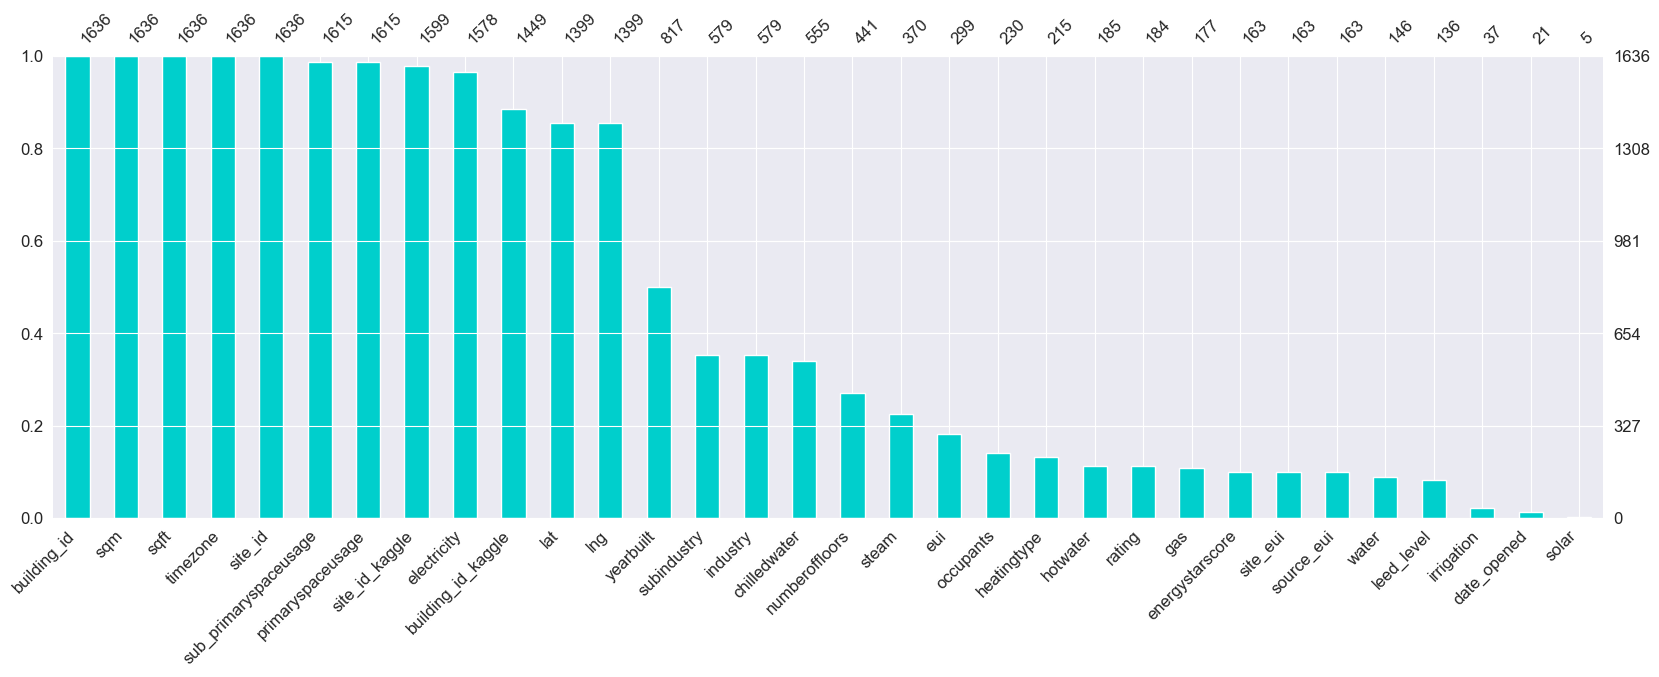

In [7]:
# Bar plot of missing values and percentage
sns.set_style("darkgrid") 
msno.bar(df, labels=True, figsize=(20,6), fontsize=12, sort="descending", color="#00cfcc")

In [9]:
missing_values = round(df.isna().sum()/len(df)*100,2)
missing_values = missing_values.sort_values(ascending=False)
missing_values

solar                   99.69
date_opened             98.72
irrigation              97.74
leed_level              91.69
water                   91.08
source_eui              90.04
site_eui                90.04
energystarscore         90.04
gas                     89.18
rating                  88.75
hotwater                88.69
heatingtype             86.86
occupants               85.94
eui                     81.72
steam                   77.38
numberoffloors          73.04
chilledwater            66.08
industry                64.61
subindustry             64.61
yearbuilt               50.06
lng                     14.49
lat                     14.49
building_id_kaggle      11.43
electricity              3.55
site_id_kaggle           2.26
primaryspaceusage        1.28
sub_primaryspaceusage    1.28
timezone                 0.00
sqm                      0.00
sqft                     0.00
site_id                  0.00
building_id              0.00
dtype: float64

#### Geographical Distribution

In [10]:
import folium
from folium.plugins import HeatMap

# Select only the numeric columns
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Create a map centered at the mean of the longitude and latitude coordinates
map_center = [df['lat'].mean(), df['lng'].mean()]
map = folium.Map(location=map_center, zoom_start=10)

# Create a list of coordinates from the dataframe
locations = df[['lat', 'lng']].values.tolist()

# Create a heatmap layer from the list of coordinates
heatmap = HeatMap(locations)

# Add the heatmap layer to the map
heatmap.add_to(map)

# Fit the bounds of the map to the heatmap layer
map.fit_bounds(heatmap.get_bounds())

# Display the map
map

#### Campuses group

<AxesSubplot:xlabel='site_id', ylabel='count'>

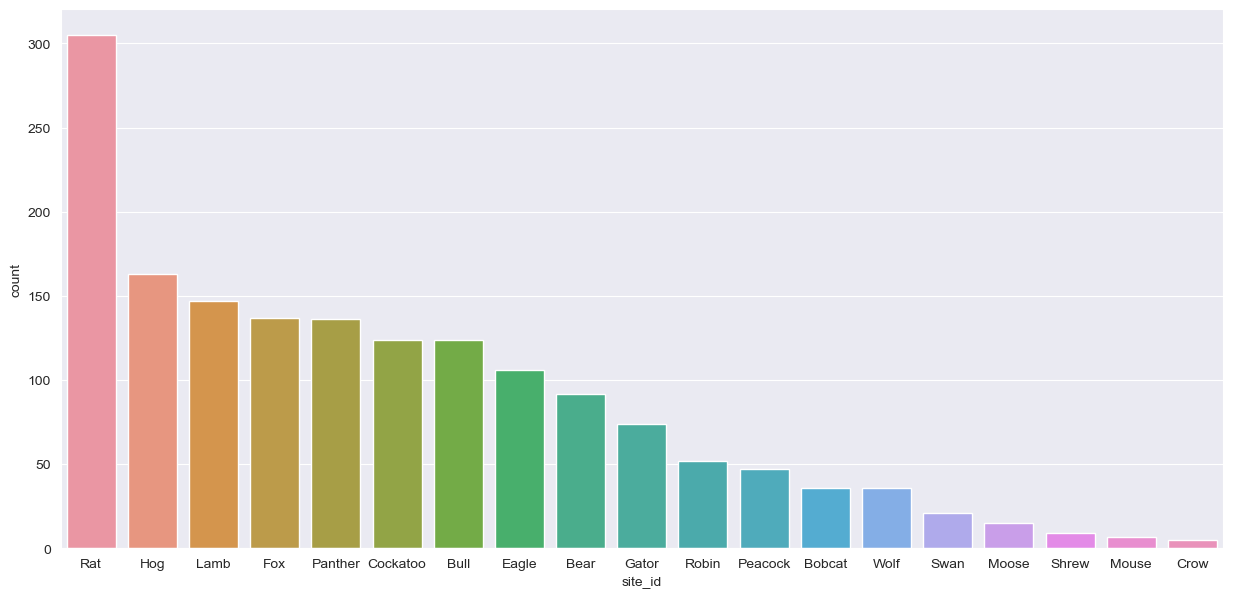

In [16]:
f, ax = plt.subplots(figsize=(15, 7))
sns.countplot(x='site_id', data=df, order=df['site_id'].value_counts().index.tolist())

#### Variables distribution

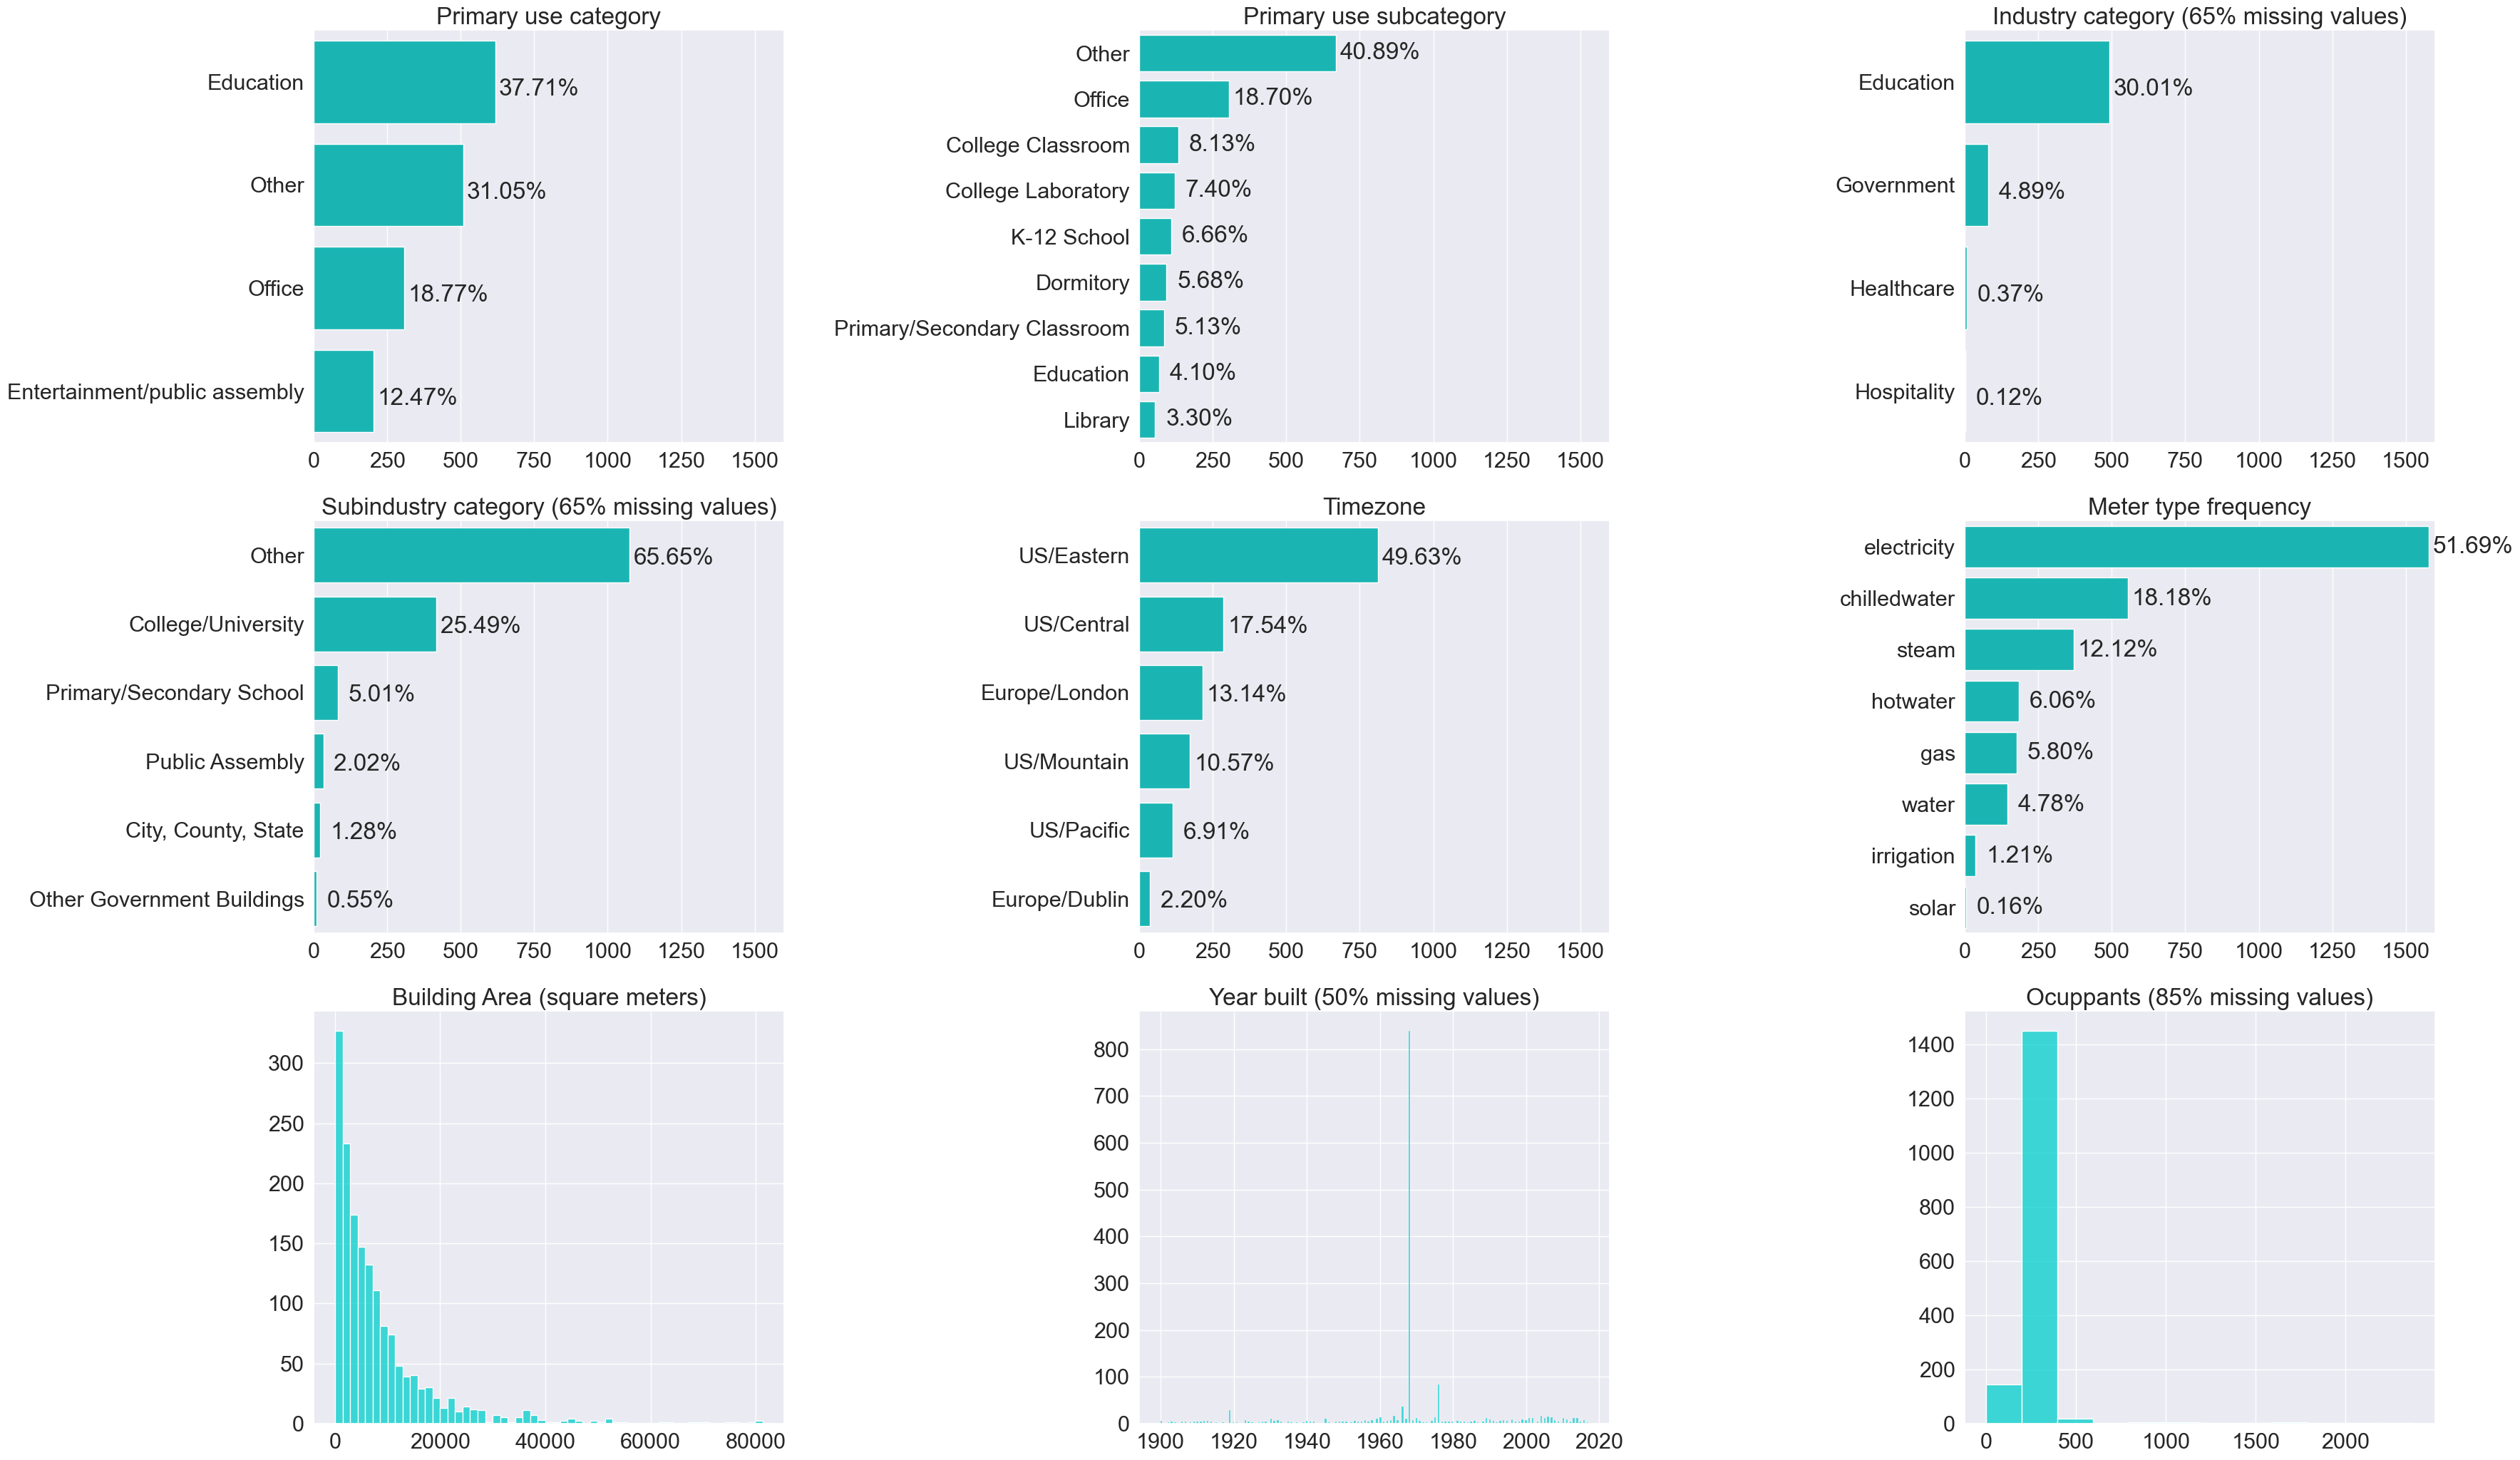

In [12]:
sns.set(rc={'figure.figsize':(36,21)})
sns.set(font_scale = 2)
f, axes = plt.subplots(3, 3)

axes = axes.flatten()

color = "#00cfcc"

# primary use category countplot in decreasing order
# Temporary dataset
top3 = list(df['primaryspaceusage'].value_counts().iloc[:3].index)
temp = df[["primaryspaceusage"]].copy()
temp.loc[temp.primaryspaceusage.isin(top3) == False, "primaryspaceusage"] = "Other"
# Plot
aX = axes[0]
g1 = sns.countplot(data=temp, y="primaryspaceusage", color= color, orient="h", ax=aX, order = temp['primaryspaceusage'].value_counts().index)
aX.title.set_text('Primary use category')
aX.set(ylabel="", xlabel="", xlim=(0,1600))
# adds percentage    
total = float(len(df)) # number of buildings
for p in g1.patches:
    width = p.get_width()
    g1.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center") 
del(top3, temp)
    
# primary use subcategory countplot in decreasing order
# Temporary dataset
top3 = list(df['sub_primaryspaceusage'].value_counts().iloc[:8].index)
temp = df[["sub_primaryspaceusage"]].copy()
temp.loc[temp.sub_primaryspaceusage.isin(top3) == False, "sub_primaryspaceusage"] = "Other"
# Plot
ax2 = axes[1]
g2 = sns.countplot(data=temp, y="sub_primaryspaceusage", color= color, orient="h", ax=ax2, order = temp['sub_primaryspaceusage'].value_counts().iloc[:16].index)
ax2.title.set_text('Primary use subcategory')
ax2.set(ylabel="", xlabel="", xlim=(0,1600))
# adds percentage    
total = float(len(df)) # number of buildings
for p in g2.patches:
    width = p.get_width()
    g2.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center") 
del(top3, temp)

# industry countplot in decreasing order
ax3 = axes[2]
g3 = sns.countplot(data=df, y="industry", color=color, ax=ax3, orient="h", order = df['industry'].value_counts().index)
ax3.title.set_text('Industry category (65% missing values)')
ax3.set(ylabel="", xlabel="", xlim=(0,1600))
# adds percentage    
total = float(len(df)) # number of buildings
for p in g3.patches:
    width = p.get_width()
    g3.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center") 
    
# subindustry countplot in decreasing order
# Temporary dataset
top3 = list(df['subindustry'].value_counts().iloc[:5].index)
temp = df[["subindustry"]].copy()
temp.loc[temp.subindustry.isin(top3) == False, "subindustry"] = "Other"
# Plot
ax4 = axes[3]
g4 = sns.countplot(data=temp, y="subindustry", color=color, ax=ax4, orient="h", order = temp['subindustry'].value_counts().index)
ax4.title.set_text('Subindustry category (65% missing values)')
ax4.set(ylabel="", xlabel="", xlim=(0,1600))
# adds percentage    
total = float(len(df)) # number of buildings
for p in g4.patches:
    width = p.get_width()
    g4.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center") 
del(top3, temp)

# timezone countplot in decreasing order
ax5 = axes[4]
g5 = sns.countplot(data=df, y="timezone", color=color, ax=ax5, orient="h", order = df['timezone'].value_counts().index)
ax5.title.set_text('Timezone')
ax5.set(ylabel="", xlabel="", xlim=(0,1600))
# adds percentage    
total = float(len(df)) # number of buildings
for p in g5.patches:
    width = p.get_width()
    g5.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center") 
    
# Meters type frequency
ax6 = axes[5]
# Temporal datafram
temp = pd.melt(df[["building_id","electricity","hotwater","chilledwater","steam","water","irrigation","gas","solar"]],id_vars = "building_id", var_name="meter")
# plot
g6 = sns.countplot(data=temp.loc[temp['value']=="Yes"], y='meter', color= color, ax=ax6, orient="h", order = temp.loc[temp['value']=="Yes"]["meter"].value_counts().index)
g6.title.set_text('Meter type frequency')
g6.set(ylabel="", xlabel="", xlim=(0,1600))
# adds percentage    
total = temp.loc[temp['value']=="Yes"]["value"].value_counts()[0] # number of meters
for p in g6.patches:
    width = p.get_width()
    g6.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center")    
del(temp)
    
# "sqm" histogram
ax7 = axes[6]
g7 = sns.histplot(df["sqm"], ax=ax7, color=color)
g7.set(ylabel="", xlabel="")
ax7.set_title('Building Area (square meters)')

# "yearbuilt" histogram
ax8 = axes[7]
g8 = sns.histplot(df["yearbuilt"].dropna(), ax=ax8, color=color)
g8.set(ylabel="", xlabel="")
ax8.set_title('Year built (50% missing values)')

# "occupants" histogram
ax9 = axes[8]
g9 = sns.histplot(df["occupants"].dropna(), ax=ax9, color=color)
g9.set(ylabel="", xlabel="")
ax9.set_title('Ocuppants (85% missing values)')
   
plt.tight_layout()

### EDA - Weather

#### Missing Values 

<AxesSubplot:>

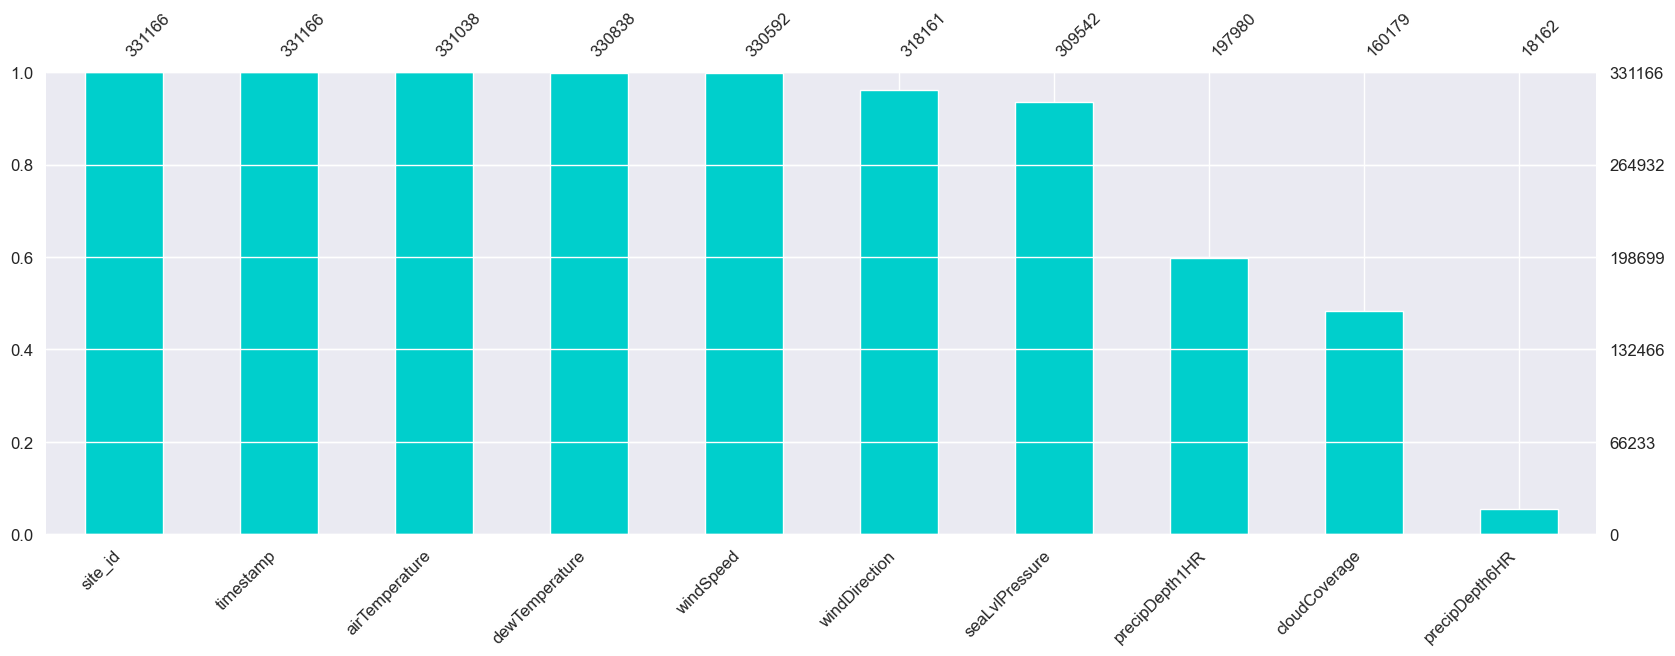

In [13]:
# Bar plot of missing values and percentage
sns.set_style("darkgrid") 
msno.bar(df_weather, labels=True, figsize=(20,6), fontsize=12, sort="descending", color="#00cfcc")

#### Correlations

<AxesSubplot:>

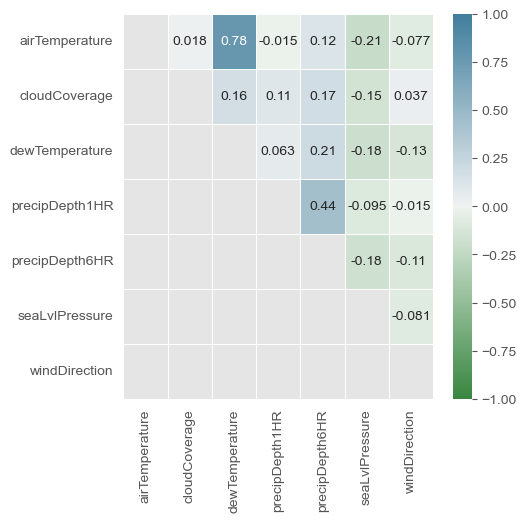

In [19]:
X = df_weather.iloc[:,2:9]
f, ax = plt.subplots(figsize=(5, 5))
plt.style.use("ggplot")
cv= X.corr().round(2)
matrix = np.tril(np.ones_like(cv))
cmap = sns.diverging_palette(130, 230, as_cmap=True)
sns.heatmap(X.corr().round(4),vmin=-1,vmax=1,annot=True,linewidth=0.6, mask=matrix, cmap=cmap, cbar_kws= {'orientation': 'vertical'})

#### Variables distribution

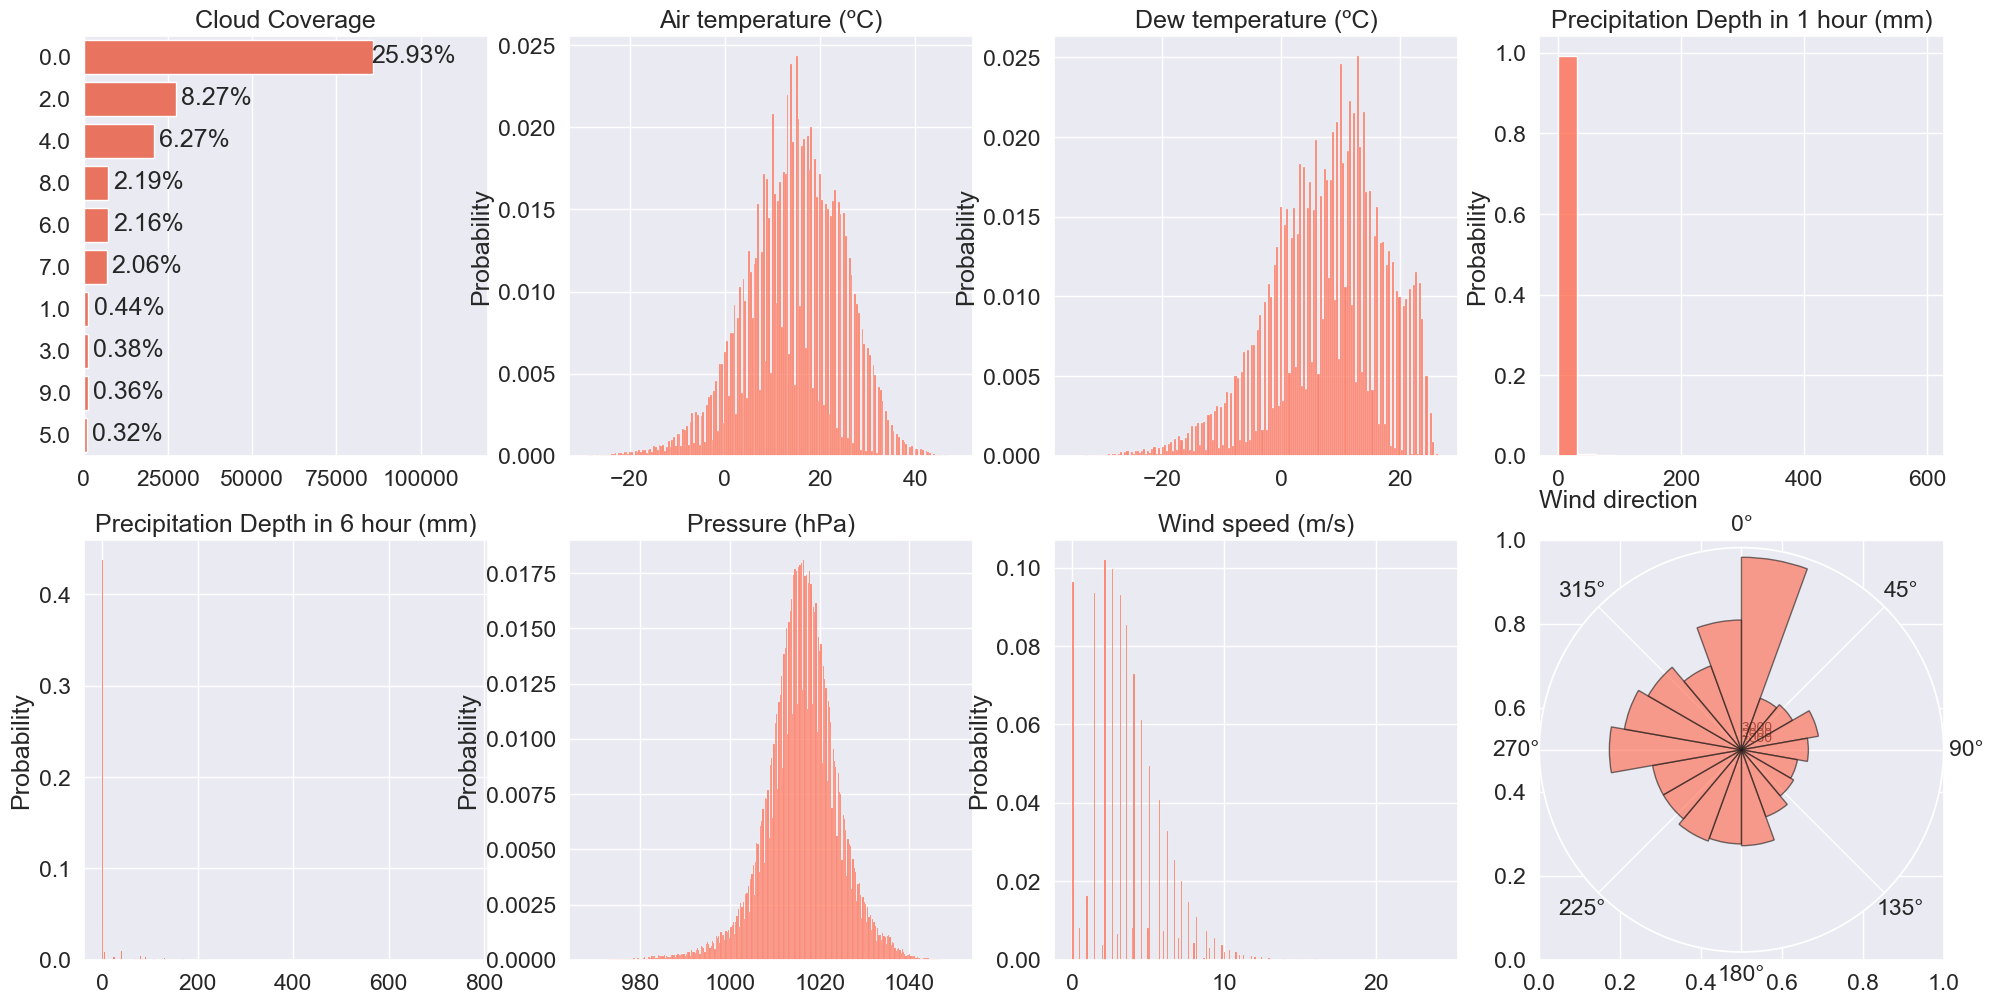

In [15]:
sns.set(rc={'figure.figsize':(24,12)}, font_scale=1.5)
f, axes = plt.subplots(2, 4, figsize=(24, 12))
axes_flat = axes.flat
color = "tomato"

# Cloud Coverage countplot in decreasing order
ax0 = next(axes_flat)
order = df_weather['cloudCoverage'].value_counts().index
g0 = sns.countplot(data=df_weather, y="cloudCoverage", color=color, orient="h", ax=ax0, order=order)
ax0.set_title('Cloud Coverage')
ax0.set(ylabel="", xlabel="", xlim=(0, 120000))
# adds percentage    
total = float(len(df_weather)) # number of rows
for p in g0.patches:
    width = p.get_width()
    g0.text(width + 12000,
            p.get_y() + p.get_height() / 1.5,
            '{:1.2%}'.format(width / total),
            ha="center") 

# "airTemperature" histogram
aX = next(axes_flat)
g1 = sns.histplot(df_weather["airTemperature"].dropna(), ax=aX, color=color, stat='probability')
aX.set_title('Air temperature (ºC)')
aX.set(xlabel="")

# "dewTemperature" histogram
ax2 = next(axes_flat)
g2 = sns.histplot(df_weather["dewTemperature"].dropna(), ax=ax2, color=color, stat='probability')
ax2.set_title('Dew temperature (ºC)')
ax2.set(xlabel="")

# "precipDepth1HR" histogram
ax3 = next(axes_flat)
g3 = sns.histplot(df_weather["precipDepth1HR"].dropna(), ax=ax3, color=color, kde_kws={'bw': 0.1}, stat='probability')
ax3.set_title('Precipitation Depth in 1 hour (mm)')
ax3.set(xlabel="")

# "precipDepth6HR" histogram
ax4 = next(axes_flat)
g4 = sns.histplot(df_weather["precipDepth6HR"].dropna(), ax=ax4, color=color, stat='probability')
ax4.set_title('Precipitation Depth in 6 hour (mm)')
ax4.set(xlabel="")

# "seaLvlPressure" histogram
ax5 = next(axes_flat)
g5 = sns.histplot(df_weather["seaLvlPressure"].dropna(), ax=ax5, color=color, stat='probability')
ax5.set_title('Pressure (hPa)')
ax5.set(xlabel="")

# "windSpeed" histogram
ax6 = next(axes_flat)
g6 = sns.histplot(df_weather["windSpeed"].dropna(), ax=ax6, color=color, stat='probability')
ax6.set_title('Wind speed (m/s)')
ax6.set(xlabel="")

# "windDirection" polar histogram
degrees = df_weather["windDirection"]
radians = np.deg2rad(df_weather["windDirection"])
bin_size = 20
a , b = np.histogram(degrees, bins=np.arange(0, 360+bin_size, bin_size))
centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
ax7 = f.add_subplot(248, projection='polar')
ax7.set_theta_zero_location("N")
ax7.set_theta_direction("clockwise")
g7 = ax7.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, color=color, alpha=0.6, edgecolor='k')
ax7.set_title('Wind direction', pad=5, loc="left")
ax7.set_rlabel_position(0)
ax7.set_yticks([1000, 2000, 3000])
ax7.set_yticklabels(["1000", "2000", "3000"])
ax7.tick_params(axis='y', labelsize=10)

#### Weather per month 

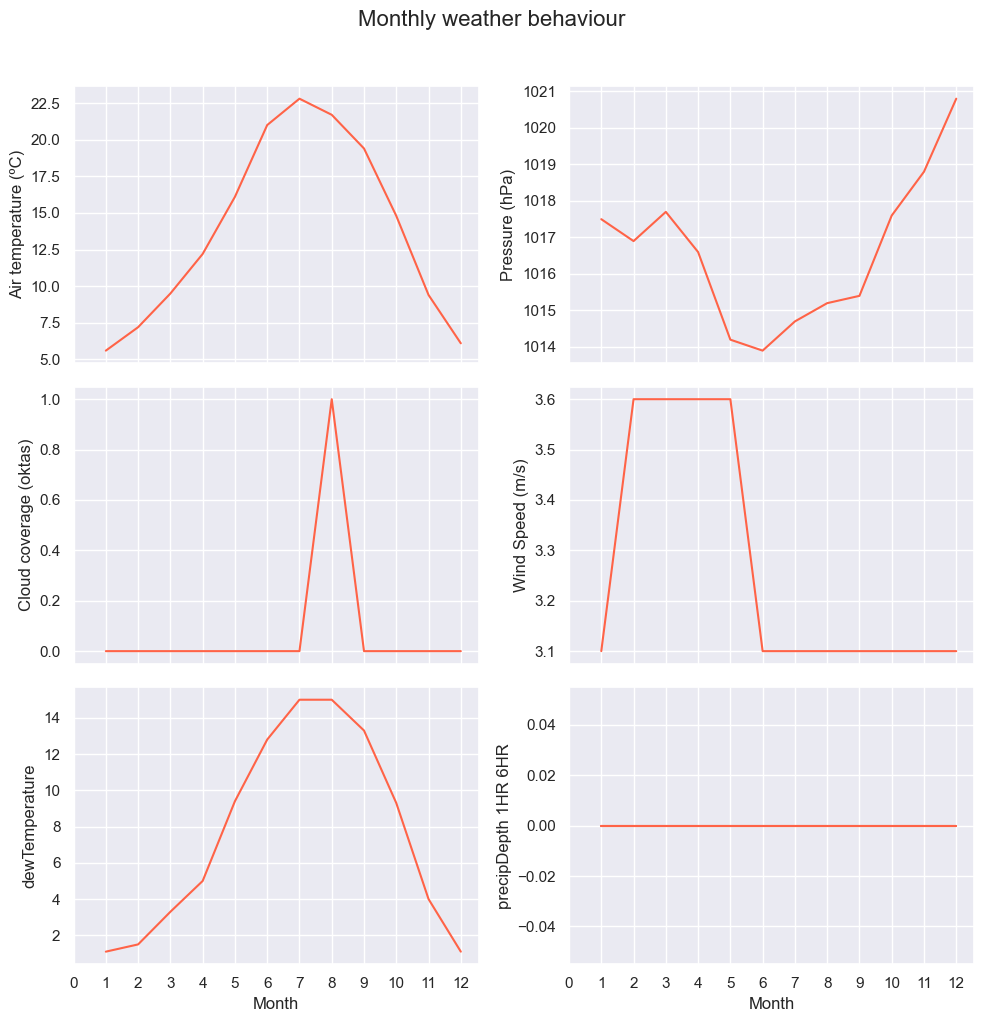

In [16]:
# datetime indexes
times = pd.DatetimeIndex(df_weather.timestamp)

# Median for each month
sns.set(rc={"figure.figsize": (10, 10)})
# sns.set(font_scale = 1)
f, axes = plt.subplots(3, 2, sharex=True)
axes = axes.flatten()
color = "tomato"

# Creates a temporal dataframe grouped by day of the year
temp = pd.DataFrame(
    df_weather.groupby([times.month]).median()[
        [
            "airTemperature",
            "cloudCoverage",
            "dewTemperature",
            "precipDepth1HR",
            "precipDepth6HR",
            "seaLvlPressure",
            "windSpeed"
        ]
    ]
).reset_index()

# plots
ax0 = axes[0]
g0 = sns.lineplot(data=temp, x="timestamp", y="airTemperature", ax=ax0, color = color)
ax0.set(ylabel="Air temperature (ºC)")

ax2 = axes[2]
g2 = sns.lineplot(data=temp, x="timestamp", y="cloudCoverage", ax=ax2, color = color)
ax2.set(ylabel="Cloud coverage (oktas)")

ax4 = axes[4]
g4 = sns.lineplot(data=temp, x="timestamp", y="dewTemperature", ax=ax4, color = color)
ax4.set(ylabel="dewTemperature")

aX = axes[1]
g1 = sns.lineplot(data=temp, x="timestamp", y="seaLvlPressure", ax=aX, color = color)
#aX.title.set_text("Pressure")
aX.set(ylabel="Pressure (hPa)")

ax3 = axes[3]
g3 = sns.lineplot(data=temp, x="timestamp", y="windSpeed", ax=ax3, color = color)
#ax3.title.set_text("Relative humidity")
ax3.set(ylabel="Wind Speed (m/s)")

ax5 = axes[5]
g5 = sns.lineplot(data=temp, x="timestamp", y="precipDepth1HR", ax=ax5, color = color)
#ax3.title.set_text("Relative humidity")
ax5.set(ylabel="precipDepth1HR")

ax6 = axes[5]
g6 = sns.lineplot(data=temp, x="timestamp", y="precipDepth6HR", ax=ax5, color = color)
ax6.set(ylabel="precipDepth 1HR 6HR")


# Customize axes
for ax in axes:
    ax.title.set_size(15)  # fontsize
    ax.set(xlabel="Month")  # X label
    ax.set_xticks(range(13))  # X range

# Figure title
plt.suptitle('Monthly weather behaviour', y=1.02, fontsize=16)

f.tight_layout()

## Focusing on a Subset of campus

<em><strong>==========================================================================================</strong></em>.

In this report, our focus will be on a subset of the datasets you provided, specifically the campus data related to the animal-coded campuses known as 'Rat', which have electricity sensors installed. This subset was chosen as it has the most information per building in terms of electricity consumption. Our analysis will involve selecting the electricity consumption data for all the buildings on the Rat campus, including parking areas, offices, lodgings, and other buildings. The objective of our analysis is to streamline the data by reducing the number of columns, resulting in a more concise dataset that is easier to analyze. By doing so, we aim to provide you with actionable insights that can inform your decision-making processes.

<em><strong>==========================================================================================</strong></em>.

In [17]:
df_electricity_cleaned = pd.read_csv("electricity_cleaned.csv",parse_dates=["timestamp"])
df_weather = pd.read_csv("weather.csv",parse_dates=["timestamp"])
df_metadata = df_metadata.loc[df_metadata.site_id == "Rat"]

In [18]:
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305 entries, 325 to 629
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   building_id            305 non-null    object 
 1   site_id                305 non-null    object 
 2   building_id_kaggle     305 non-null    float64
 3   site_id_kaggle         305 non-null    float64
 4   primaryspaceusage      305 non-null    object 
 5   sub_primaryspaceusage  305 non-null    object 
 6   sqm                    305 non-null    float64
 7   sqft                   305 non-null    float64
 8   lat                    305 non-null    float64
 9   lng                    305 non-null    float64
 10  timezone               305 non-null    object 
 11  electricity            305 non-null    object 
 12  hotwater               0 non-null      object 
 13  chilledwater           0 non-null      object 
 14  steam                  0 non-null      object 
 15  wate

In [19]:
df_metadata = df_metadata.dropna(axis=1, how='all')
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305 entries, 325 to 629
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   building_id            305 non-null    object 
 1   site_id                305 non-null    object 
 2   building_id_kaggle     305 non-null    float64
 3   site_id_kaggle         305 non-null    float64
 4   primaryspaceusage      305 non-null    object 
 5   sub_primaryspaceusage  305 non-null    object 
 6   sqm                    305 non-null    float64
 7   sqft                   305 non-null    float64
 8   lat                    305 non-null    float64
 9   lng                    305 non-null    float64
 10  timezone               305 non-null    object 
 11  electricity            305 non-null    object 
 12  yearbuilt              305 non-null    float64
 13  numberoffloors         305 non-null    float64
 14  occupants              305 non-null    float64
dtypes: f

### We Select Weather for Rat Campuses

In [20]:
df_weather = df_weather.loc[df_weather.site_id == "Rat"]
df_weather

,timestamp,site_id,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
52603,2016-01-01 00:00:00,Rat,7.20,NaN,0.00,0.00,NaN,1021.50,350.00,5.10
52604,2016-01-01 01:00:00,Rat,6.70,8.00,0.00,0.00,NaN,1021.10,340.00,3.60
52605,2016-01-01 02:00:00,Rat,5.60,NaN,0.00,0.00,NaN,1020.80,350.00,3.10
52606,2016-01-01 03:00:00,Rat,5.60,NaN,0.00,0.00,NaN,1021.10,340.00,3.60
52607,2016-01-01 04:00:00,Rat,5.60,6.00,-1.10,0.00,NaN,1020.70,320.00,3.10
...,...,...,...,...,...,...,...,...,...,...
70137,2017-12-31 19:00:00,Rat,-7.20,2.00,-15.00,NaN,NaN,1029.50,320.00,4.60
70138,2017-12-31 20:00:00,Rat,-7.20,0.00,-15.60,0.00,NaN,1030.00,310.00,4.60
70139,2017-12-31 21:00:00,Rat,-7.80,0.00,-15.60,0.00,NaN,1030.30,330.00,3.60
70140,2017-12-31 22:00:00,Rat,-8.30,0.00,-16.70,0.00,NaN,1030.40,340.00,4.60


### Filter electricity columns

In [21]:
Rat_build = df_electricity_cleaned.filter(like='Rat').columns.tolist()
Rat_build = ["timestamp"] + Rat_build
df_electricity_cleaned = df_electricity_cleaned[Rat_build]
df_electricity_cleaned

,timestamp,Rat_public_Emilee,Rat_public_Nell,Rat_retail_Jeffrey,Rat_education_Adrian,Rat_office_Annis,Rat_assembly_Suzanne,Rat_office_Jessica,Rat_education_Lee,Rat_education_Alfonso,Rat_public_Frederick,Rat_education_Kathryn,Rat_public_Leta,Rat_education_Keith,Rat_education_Morton,Rat_other_Al,Rat_education_Willy,Rat_education_Davis,Rat_education_Edmund,Rat_assembly_Jamie,Rat_education_Conrad,Rat_public_Kelly,Rat_education_Verna,Rat_public_Sean,Rat_public_Kathleen,Rat_education_Kandice,Rat_warehouse_Maegan,Rat_assembly_Michel,Rat_public_Becky,Rat_office_Colby,...,Rat_assembly_Damaris,Rat_public_Marcellus,Rat_public_Muriel,Rat_assembly_Monica,Rat_assembly_Silvia,Rat_education_Dianne,Rat_public_Ramon,Rat_education_Esther,Rat_education_Guillermo,Rat_public_Lea,Rat_health_Shane,Rat_education_Alonzo,Rat_education_Susana,Rat_education_Colin,Rat_assembly_Lillie,Rat_assembly_Frieda,Rat_education_Dann,Rat_public_Stacey,Rat_education_Jeanne,Rat_public_Angelina,Rat_public_Sana,Rat_office_Rosemary,Rat_public_Desiree,Rat_education_Lonnie,Rat_education_Jena,Rat_office_Loyd,Rat_education_Tania,Rat_assembly_Rosemarie,Rat_education_Angelica,Rat_lodging_Christine
0,2016-01-01 00:00:00,14.59,47.92,39.51,41.75,26.26,2.32,670.65,284.52,214.64,15.24,567.13,13.27,80.15,82.64,45.57,63.04,66.82,27.84,34.13,NaN,15.17,51.76,18.88,16.50,107.44,7.02,8.72,17.01,1701.70,...,9.33,7.15,136.80,36.63,8.66,129.79,21.40,57.77,91.63,89.34,1013.78,56.44,19.20,27.70,9.39,72.04,150.58,10.60,NaN,22.23,1068.48,15.11,16.02,33.33,102.92,41.56,321.70,7.34,48.22,40.72
1,2016-01-01 01:00:00,14.67,47.52,39.45,41.23,26.50,2.44,675.97,290.52,208.75,14.42,551.65,12.76,76.98,83.32,46.16,63.27,66.97,26.58,34.50,NaN,13.32,53.34,17.83,16.66,105.84,7.15,8.69,16.93,1714.25,...,9.31,6.91,137.18,36.59,8.57,129.82,21.64,53.86,87.61,89.54,988.38,56.15,19.20,28.21,9.41,70.09,150.19,9.77,NaN,21.68,1070.64,15.38,13.58,32.82,103.94,38.28,277.88,6.45,48.16,48.66
2,2016-01-01 02:00:00,14.58,47.42,38.67,41.53,25.42,2.44,673.52,292.80,208.63,14.75,550.38,12.31,78.62,83.40,60.43,63.36,67.89,27.38,34.83,NaN,13.28,53.24,19.55,16.36,106.95,7.17,8.67,16.38,1731.22,...,9.30,6.74,140.12,36.41,8.49,128.01,20.01,57.94,84.91,90.62,996.25,56.83,19.20,27.85,10.06,68.89,149.62,10.12,NaN,21.00,1072.56,15.70,12.57,33.17,104.95,33.01,279.91,6.51,47.42,45.65
3,2016-01-01 03:00:00,14.57,47.44,38.99,41.27,24.83,2.44,671.66,289.89,206.10,14.92,553.18,12.71,80.86,82.75,59.83,63.33,67.12,27.62,35.15,NaN,13.03,53.62,19.74,16.00,108.27,7.14,8.69,15.78,1773.67,...,9.11,6.68,149.12,37.72,8.61,123.15,30.26,57.51,90.52,90.92,966.22,56.75,19.20,27.94,10.85,72.01,148.58,9.58,NaN,21.79,1072.56,15.29,12.87,32.84,103.46,32.96,280.22,6.47,48.46,41.25
4,2016-01-01 04:00:00,14.92,47.66,37.32,41.50,24.05,2.44,664.82,290.01,206.06,15.42,557.38,13.44,81.04,82.82,59.42,63.45,67.28,29.09,35.07,NaN,12.14,53.69,19.47,15.94,104.69,7.22,8.71,15.91,1926.96,...,8.62,6.95,144.30,36.37,8.74,130.57,28.75,60.45,95.46,90.81,984.39,57.81,19.20,27.92,10.84,68.29,147.23,10.25,NaN,21.38,1069.68,15.62,13.24,33.54,103.94,32.38,282.89,7.23,48.00,49.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,2017-12-31 19:00:00,20.76,58.74,50.20,43.32,36.46,4.36,684.79,486.87,229.01,16.10,727.92,14.03,162.01,104.34,80.04,NaN,48.08,40.56,119.72,141.30,18.79,70.33,44.74,65.39,75.29,12.38,8.20,31.20,2609.77,...,8.64,8.44,49.50,83.94,28.77,NaN,71.23,146.30,130.57,NaN,997.41,NaN,NaN,10.68,63.39,96.12,147.62,19.37,50.34,27.68,NaN,17.95,15.85,37.47,121.52,55.87,243.35,5.85,NaN,34.96
17540,2017-12-31 20:00:00,20.65,59.83,48.96,42.88,39.48,4.32,684.88,471.42,216.05,16.16,723.52,12.68,161.08,105.63,78.98,NaN,47.67,41.33,120.24,130.77,19.10,70.72,44.48,65.63,114.31,12.84,8.26,31.77,2623.47,...,8.63,8.46,53.26,85.90,29.25,NaN,75.89,148.63,130.57,NaN,971.37,NaN,NaN,10.70,63

### Melt: Transfrom the date from wide to long

In [22]:
df_electricity_cleaned = df_electricity_cleaned.melt(id_vars="timestamp", var_name="building_id", value_name="meter_reading")
df_electricity_cleaned

,timestamp,building_id,meter_reading
0,2016-01-01 00:00:00,Rat_public_Emilee,14.59
1,2016-01-01 01:00:00,Rat_public_Emilee,14.67
2,2016-01-01 02:00:00,Rat_public_Emilee,14.58
3,2016-01-01 03:00:00,Rat_public_Emilee,14.57
4,2016-01-01 04:00:00,Rat_public_Emilee,14.92
...,...,...,...
5350915,2017-12-31 19:00:00,Rat_lodging_Christine,34.96
5350916,2017-12-31 20:00:00,Rat_lodging_Christine,33.74
5350917,2017-12-31 21:00:00,Rat_lodging_Christine,32.42
5350918,2017-12-31 22:00:00,Rat_lodging_Christine,30.81


### Merge Metadata and Energy

In [23]:
df_electricity_cleaned = pd.merge(df_electricity_cleaned, df_metadata, how="left", on="building_id")
df_electricity_cleaned

,timestamp,building_id,meter_reading,site_id,building_id_kaggle,site_id_kaggle,primaryspaceusage,sub_primaryspaceusage,sqm,sqft,lat,lng,timezone,electricity,yearbuilt,numberoffloors,occupants
0,2016-01-01 00:00:00,Rat_public_Emilee,14.59,Rat,466.00,3.00,Public services,Library,2090.30,22500.00,38.90,-77.01,US/Eastern,Yes,1968.24,3.61,263.22
1,2016-01-01 01:00:00,Rat_public_Emilee,14.67,Rat,466.00,3.00,Public services,Library,2090.30,22500.00,38.90,-77.01,US/Eastern,Yes,1968.24,3.61,263.22
2,2016-01-01 02:00:00,Rat_public_Emilee,14.58,Rat,466.00,3.00,Public services,Library,2090.30,22500.00,38.90,-77.01,US/Eastern,Yes,1968.24,3.61,263.22
3,2016-01-01 03:00:00,Rat_public_Emilee,14.57,Rat,466.00,3.00,Public services,Library,2090.30,22500.00,38.90,-77.01,US/Eastern,Yes,1968.24,3.61,263.22
4,2016-01-01 04:00:00,Rat_public_Emilee,14.92,Rat,466.00,3.00,Public services,Library,2090.30,22500.00,38.90,-77.01,US/Eastern,Yes,1968.24,3.61,263.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5350915,2017-12-31 19:00:00,Rat_lodging_Christine,34.96,Rat,478.00,3.00,Lodging/residential,Other - Lodging/Residential,2906.30,31283.00,38.90,-77.01,US/Eastern,Yes,1935.00,3.61,263.22
5350916,2017-12-31 20:00:00,Rat_lodging_Christine,33.74,Rat,478.00,3.00,Lodging/residential,Other - Lodging/Residential,2906.30,31283.00,38.90,-77.01,US/Eastern,Yes,1935.00,3.61,263.22
5350917,2017-12-31 21:00:00,Rat_lodging_Christine,32.42,Rat,478.00,3.00,Lodging/residential,Other - Lodging/Residential,2906.30,31283.00,38.90,-77.01,US/Eastern,Yes,1935.00,3.61,263.22
5350918,2017-12-31 22:00:00,Rat_lodging_Christine,30.81,Rat,478.00,3.00,Lodging/residential,Other - Lodging/Residential,2906.30,31283.00,38.90,-77.01,US/Eastern,Yes,1935.00,3.61,263.22


### Merge Electricity with Weather

In [24]:
df_electricity_cleaned = pd.merge(df_electricity_cleaned, df_weather, how="left", on=["timestamp","site_id"])
df_electricity_cleaned

,timestamp,building_id,meter_reading,site_id,building_id_kaggle,site_id_kaggle,primaryspaceusage,sub_primaryspaceusage,sqm,sqft,lat,lng,timezone,electricity,yearbuilt,numberoffloors,occupants,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
0,2016-01-01 00:00:00,Rat_public_Emilee,14.59,Rat,466.00,3.00,Public services,Library,2090.30,22500.00,38.90,-77.01,US/Eastern,Yes,1968.24,3.61,263.22,7.20,NaN,0.00,0.00,NaN,1021.50,350.00,5.10
1,2016-01-01 01:00:00,Rat_public_Emilee,14.67,Rat,466.00,3.00,Public services,Library,2090.30,22500.00,38.90,-77.01,US/Eastern,Yes,1968.24,3.61,263.22,6.70,8.00,0.00,0.00,NaN,1021.10,340.00,3.60
2,2016-01-01 02:00:00,Rat_public_Emilee,14.58,Rat,466.00,3.00,Public services,Library,2090.30,22500.00,38.90,-77.01,US/Eastern,Yes,1968.24,3.61,263.22,5.60,NaN,0.00,0.00,NaN,1020.80,350.00,3.10
3,2016-01-01 03:00:00,Rat_public_Emilee,14.57,Rat,466.00,3.00,Public services,Library,2090.30,22500.00,38.90,-77.01,US/Eastern,Yes,1968.24,3.61,263.22,5.60,NaN,0.00,0.00,NaN,1021.10,340.00,3.60
4,2016-01-01 04:00:00,Rat_public_Emilee,14.92,Rat,466.00,3.00,Public services,Library,2090.30,22500.00,38.90,-77.01,US/Eastern,Yes,1968.24,3.61,263.22,5.60,6.00,-1.10,0.00,NaN,1020.70,320.00,3.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5350915,2017-12-31 19:00:00,Rat_lodging_Christine,34.96,Rat,478.00,3.00,Lodging/residential,Other - Lodging/Residential,2906.30,31283.00,38.90,-77.01,US/Eastern,Yes,1935.00,3.61,263.22,-7.20,2.00,-15.00,NaN,NaN,1029.50,320.00,4.60
5350916,2017-12-31 20:00:00,Rat_lodging_Christine,33.74,Rat,478.00,3.00,Lodging/residential,Other - Lodging/Residential,2906.30,31283.00,38.90,-77.01,US/Eastern,Yes,1935.00,3.61,263.22,-7.20,0.00,-15.60,0.00,NaN,1030.00,310.00,4.60
5350917,2017-12-31 21:00:00,Rat_lodging_Christine,32.42,Rat,478.00,3.00,Lodging/residential,Other - Lodging/Residential,2906.30,31283.00,38.90,-77.01,US/Eastern,Yes,1935.00,3.61,263.22,-7.80,0.00,-15.60,0.00,NaN,1030.30,330.00,3.60
5350918,2017-12-31 22:00:00,Rat_lodging_Christine,30.81,Rat,478.00,3.00,Lodging/residential,Other - Lodging/Residential,2906.30,31283.00,38.90,-77.01,US/Eastern,Yes,1935.00,3.61,263.22,-8.30,0.00,-16.70,0.00,NaN,1030.40,340.00,4.60


In [25]:
missings = df_electricity_cleaned.isna()
(missings.sum()/len(df_electricity_cleaned))*100

timestamp                0.00
building_id              0.00
meter_reading            8.29
site_id                  0.00
building_id_kaggle       0.00
site_id_kaggle           0.00
primaryspaceusage        0.00
sub_primaryspaceusage    0.00
sqm                      0.00
sqft                     0.00
lat                      0.00
lng                      0.00
timezone                 0.00
electricity              0.00
yearbuilt                0.00
numberoffloors           0.00
occupants                0.00
airTemperature           0.06
cloudCoverage           42.76
dewTemperature           0.08
precipDepth1HR           0.31
precipDepth6HR          96.05
seaLvlPressure           1.74
windDirection            1.68
windSpeed                0.09
dtype: float64

## Final Dataset

<em><strong>==========================================================================================</strong></em>.

After merging the metadata, weather, and electricity consumption datasets, our next step is to clean the final dataset. To start, we will drop all variables that are not relevant or are redundant for our analysis. Then, we will focus on detecting and treating any missing values. Initially, we will drop all missing values from our target variable, `meter_reading` , and input the `median of airTemperature, dewTemperature, precipDepth1HR, seaLvlPressure, windDirection`, and `windSpeed`.

In addition, we have added two new columns, `year` and `month`, to better understand the time dimension of the data. We have also created a Onehotencoder for the primary usage of the building, which will help us categorize and analyze the data more effectively.

Finally, we will specify the data types of some columns to import the file as a `CSV` . This process will ensure that our final dataset is clean and well-structured, making it easier to analyze and derive insights from.

<em><strong>==========================================================================================</strong></em>.

In [26]:
df = df_electricity_cleaned
df = df.drop(['building_id', 'site_id', 'site_id_kaggle','sub_primaryspaceusage','lat','lng','timezone','electricity','sqft', 'cloudCoverage', 'numberoffloors', 'occupants', 'precipDepth6HR'], axis=1)
missings = df.isna()
missings.sum()/len(df)*100

timestamp            0.00
meter_reading        8.29
building_id_kaggle   0.00
primaryspaceusage    0.00
sqm                  0.00
yearbuilt            0.00
airTemperature       0.06
dewTemperature       0.08
precipDepth1HR       0.31
seaLvlPressure       1.74
windDirection        1.68
windSpeed            0.09
dtype: float64

### Treat missing values 

In [27]:
df.dropna(subset=['meter_reading'], inplace=True)
missings = df.isna()
missings.sum()/len(df)*100

timestamp            0.00
meter_reading        0.00
building_id_kaggle   0.00
primaryspaceusage    0.00
sqm                  0.00
yearbuilt            0.00
airTemperature       0.06
dewTemperature       0.08
precipDepth1HR       0.32
seaLvlPressure       1.75
windDirection        1.69
windSpeed            0.09
dtype: float64

In [28]:
#df = df.fillna(df.mean())

df['airTemperature'] = df['airTemperature'].fillna(df['airTemperature'].median())
df['dewTemperature'] = df['dewTemperature'].fillna(df['dewTemperature'].median())
df['precipDepth1HR'] = df['precipDepth1HR'].fillna(df['precipDepth1HR'].median())
df['seaLvlPressure'] = df['seaLvlPressure'].fillna(df['seaLvlPressure'].median())
df['windDirection'] = df['windDirection'].fillna(df['windDirection'].median())
df['windSpeed'] = df['windSpeed'].fillna(df['windSpeed'].median())

In [29]:
missings = df.isna()
missings.sum()/len(df)*100

timestamp            0.00
meter_reading        0.00
building_id_kaggle   0.00
primaryspaceusage    0.00
sqm                  0.00
yearbuilt            0.00
airTemperature       0.00
dewTemperature       0.00
precipDepth1HR       0.00
seaLvlPressure       0.00
windDirection        0.00
windSpeed            0.00
dtype: float64

In [30]:
df.insert(1, "year", df.timestamp.dt.year)
df.insert(2, "month", df.timestamp.dt.month)

### Primary Usage Onehot encoder 

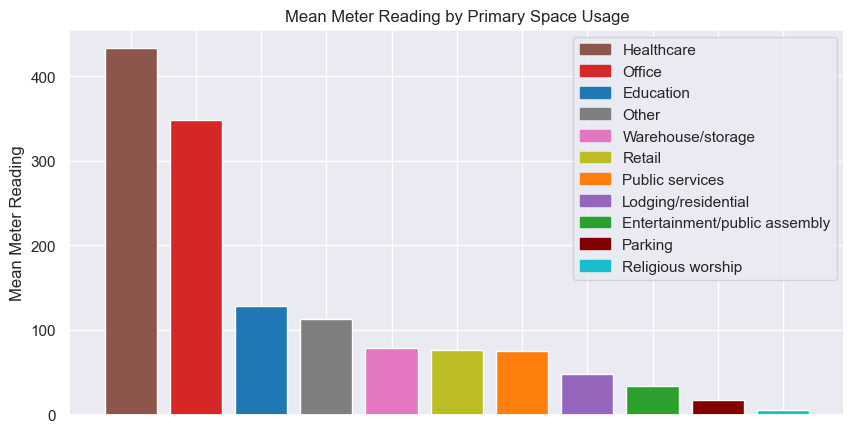

In [31]:
# group the data by primaryspaceusage and calculate the mean meter_reading for each group
grouped = df.groupby('primaryspaceusage')['meter_reading'].mean().sort_values(ascending=False)

# define a dictionary that maps each unique primaryspaceusage value to a color
colors = {'Education': '#1f77b4', 
          'Public services': '#ff7f0e',
          'Entertainment/public assembly':'#2ca02c',
          'Office': '#d62728',
          'Lodging/residential': '#9467bd',
          'Healthcare': '#8c564b',
          'Warehouse/storage': '#e377c2',
          'Other': '#7f7f7f',
          'Retail': '#bcbd22',
          'Religious worship': '#17becf',
          'Parking': '#800000'}

# create a bar plot of the mean meter_reading for each primaryspaceusage, using the specified colors
bars = plt.bar(grouped.index, grouped.values, color=[colors.get(x, '#333333') for x in grouped.index])

plt.title('Mean Meter Reading by Primary Space Usage')
plt.ylabel('Mean Meter Reading')

# remove x-axis labels
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# sort the labels in descending order based on the corresponding mean meter_reading
labels = [label for label in grouped.index]
labels.sort(reverse=True, key=lambda x: grouped[x])

# create legend with the corresponding colors and sorted labels
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

# adjust the size of the plot to make it wider
fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.show()

In [32]:
# Count the number of each primaryspaceusage
count = df.primaryspaceusage.value_counts()

# Calculate the relative frequency for each primaryspaceusage
relative_freq = count / count.sum() * 100

# Calculate the cumulative relative frequency for each primaryspaceusage
cumulative_relative_freq = relative_freq.cumsum()

# Create the data frame
results_df = pd.DataFrame({
    'Count': count,
    'Relative Frequency': relative_freq,
    'Cumulative Relative Frequency': cumulative_relative_freq
})

# Display the data frame
results_df

,Count,Relative Frequency,Cumulative Relative Frequency
Education,1682972,34.30,34.30
Public services,1527937,31.14,65.43
Entertainment/public assembly,787844,16.05,81.49
Office,407621,8.31,89.79
Lodging/residential,180513,3.68,93.47
Healthcare,111460,2.27,95.74
Warehouse/storage,86635,1.77,97.51
Other,69721,1.42,98.93
Retail,17517,0.36,99.29
Religious worship,17487,0.36,99.64


In [33]:
# Get columns with less than 10% of data
s = (df.primaryspaceusage.value_counts() < len(df)*0.1)

# Convert to list
categories_under_10pct = list(s[s].index)
print(categories_under_10pct)

# Replace for category "Other"
df = df.replace(categories_under_10pct, "Other")

# Check

# Calculate the relative frequency for each primaryspaceusage
relative_freq = df.primaryspaceusage.value_counts(normalize=True) * 100

# Calculate the cumulative relative frequency for each primaryspaceusage
cumulative_relative_freq = relative_freq.cumsum()

# Create the data frame
results_df = pd.DataFrame({
    'Relative Frequency': relative_freq,
    'Cumulative Relative Frequency': cumulative_relative_freq
})

# Display the data frame
results_df

['Office', 'Lodging/residential', 'Healthcare', 'Warehouse/storage', 'Other', 'Retail', 'Religious worship', 'Parking']


,Relative Frequency,Cumulative Relative Frequency
Education,34.30,34.30
Public services,31.14,65.43
Other,18.51,83.95
Entertainment/public assembly,16.05,100.00


In [34]:
dummies = pd.get_dummies(df['primaryspaceusage'])

# concatenate the original dataframe and the dummy variables
df = pd.concat([df, dummies], axis=1)

# drop the original primaryspaceusage column
df = df.drop('primaryspaceusage', axis=1)

df

,timestamp,year,month,meter_reading,building_id_kaggle,sqm,yearbuilt,airTemperature,dewTemperature,precipDepth1HR,seaLvlPressure,windDirection,windSpeed,Education,Entertainment/public assembly,Other,Public services
0,2016-01-01 00:00:00,2016,1,14.59,466.00,2090.30,1968.24,7.20,0.00,0.00,1021.50,350.00,5.10,0,0,0,1
1,2016-01-01 01:00:00,2016,1,14.67,466.00,2090.30,1968.24,6.70,0.00,0.00,1021.10,340.00,3.60,0,0,0,1
2,2016-01-01 02:00:00,2016,1,14.58,466.00,2090.30,1968.24,5.60,0.00,0.00,1020.80,350.00,3.10,0,0,0,1
3,2016-01-01 03:00:00,2016,1,14.57,466.00,2090.30,1968.24,5.60,0.00,0.00,1021.10,340.00,3.60,0,0,0,1
4,2016-01-01 04:00:00,2016,1,14.92,466.00,2090.30,1968.24,5.60,-1.10,0.00,1020.70,320.00,3.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5350915,2017-12-31 19:00:00,2017,12,34.96,478.00,2906.30,1935.00,-7.20,-15.00,0.00,1029.50,320.00,4.60,0,0,1,0
5350916,2017-12-31 20:00:00,2017,12,33.74,478.00,2906.30,1935.00,-7.20,-15.60,0.00,1030.00,310.00,4.60,0,0,1,0
5350917,2017-12-31 21:00:00,2017,12,32.42,478.00,2906.30,1935.00,-7.80,-15.60,0.00,1030.30,330.00,3.60,0,0,1,0
5350918,2017-12-31 22:00:00,2017,12,30.81,478.00,2906.30,1935.00,-8.30,-16.70,0.00,1030.40,340.00,4.60,0,0,1,0


### Specifying right types 

In [35]:
df['yearbuilt'] = df['yearbuilt'].astype(int)
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df

,timestamp,year,month,meter_reading,building_id_kaggle,sqm,yearbuilt,airTemperature,dewTemperature,precipDepth1HR,seaLvlPressure,windDirection,windSpeed,Education,Entertainment/public assembly,Other,Public services
0,2016-01-01 00:00:00,2016,1,14.59,466.00,2090.30,1968,7.20,0.00,0.00,1021.50,350.00,5.10,0,0,0,1
1,2016-01-01 01:00:00,2016,1,14.67,466.00,2090.30,1968,6.70,0.00,0.00,1021.10,340.00,3.60,0,0,0,1
2,2016-01-01 02:00:00,2016,1,14.58,466.00,2090.30,1968,5.60,0.00,0.00,1020.80,350.00,3.10,0,0,0,1
3,2016-01-01 03:00:00,2016,1,14.57,466.00,2090.30,1968,5.60,0.00,0.00,1021.10,340.00,3.60,0,0,0,1
4,2016-01-01 04:00:00,2016,1,14.92,466.00,2090.30,1968,5.60,-1.10,0.00,1020.70,320.00,3.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5350915,2017-12-31 19:00:00,2017,12,34.96,478.00,2906.30,1935,-7.20,-15.00,0.00,1029.50,320.00,4.60,0,0,1,0
5350916,2017-12-31 20:00:00,2017,12,33.74,478.00,2906.30,1935,-7.20,-15.60,0.00,1030.00,310.00,4.60,0,0,1,0
5350917,2017-12-31 21:00:00,2017,12,32.42,478.00,2906.30,1935,-7.80,-15.60,0.00,1030.30,330.00,3.60,0,0,1,0
5350918,2017-12-31 22:00:00,2017,12,30.81,478.00,2906.30,1935,-8.30,-16.70,0.00,1030.40,340.00,4.60,0,0,1,0


### Check for outliers

In [36]:
features = df.iloc[:, [3, 5,7,8,9,10,11,12,13,14,15,16]]

In [37]:
features.describe()

,meter_reading,sqm,airTemperature,dewTemperature,precipDepth1HR,seaLvlPressure,windDirection,windSpeed,Education,Entertainment/public assembly,Other,Public services
count,4907192.00,4907192.00,4907192.00,4907192.00,4907192.00,4907192.00,4907192.00,4907192.00,4907192.00,4907192.00,4907192.00,4907192.00
mean,117.03,6988.29,15.62,8.31,0.70,1017.67,186.00,3.92,0.34,0.16,0.19,0.31
std,241.87,10792.70,9.80,10.70,5.88,7.20,110.23,2.27,0.47,0.37,0.39,0.46
min,0.01,74.40,-10.60,-22.80,-1.00,990.50,0.00,0.00,0.00,0.00,0.00,0.00
25%,18.24,1211.80,7.80,0.60,0.00,1013.40,90.00,2.60,0.00,0.00,0.00,0.00
50%,46.02,3396.70,16.10,9.40,0.00,1017.50,190.00,3.60,0.00,0.00,0.00,0.00
75%,107.32,7785.30,23.90,17.80,0.00,1022.00,290.00,5.10,1.00,0.00,0.00,1.00
max,3095.44,79000.40,37.80,26.70,198.00,1043.00,360.00,17.00,1.00,1.00,1.00,1.00


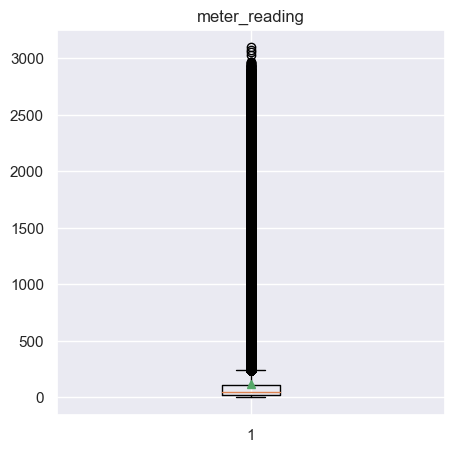

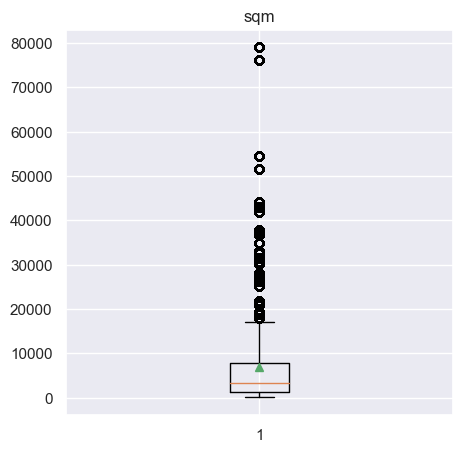

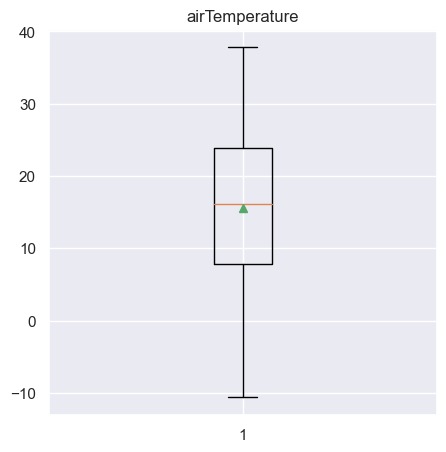

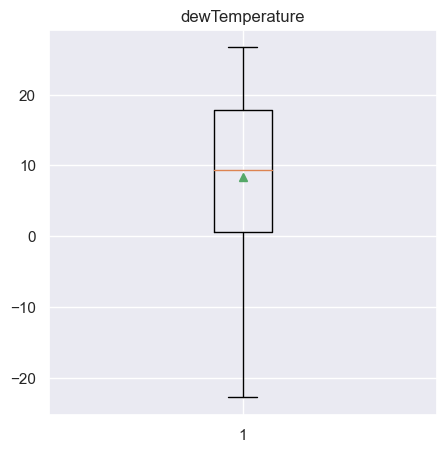

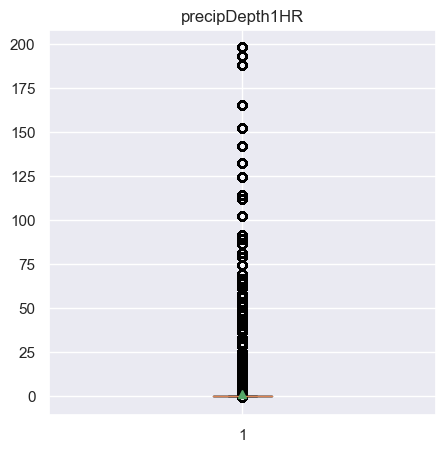

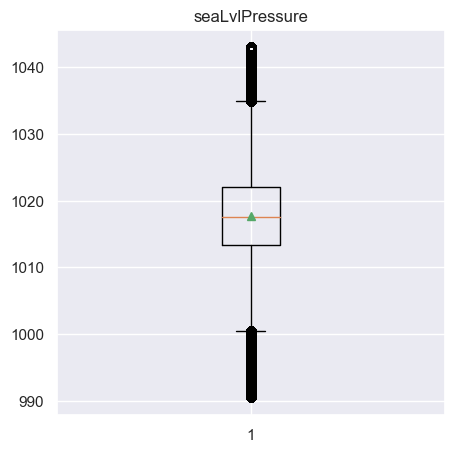

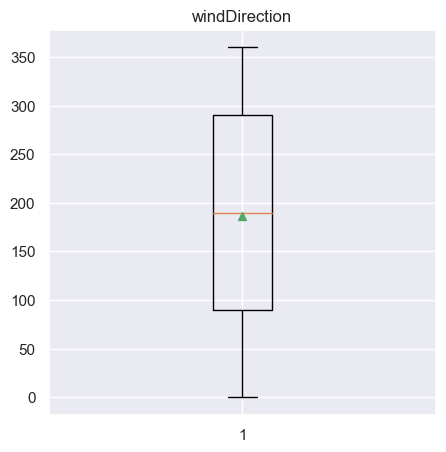

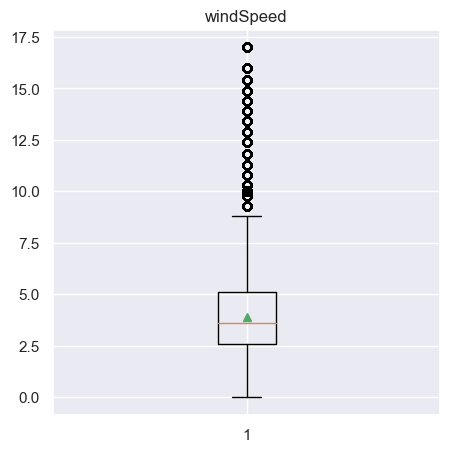

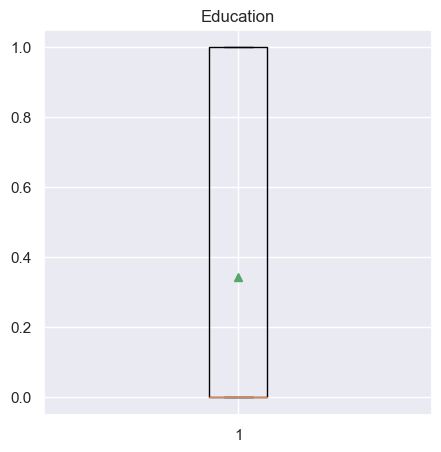

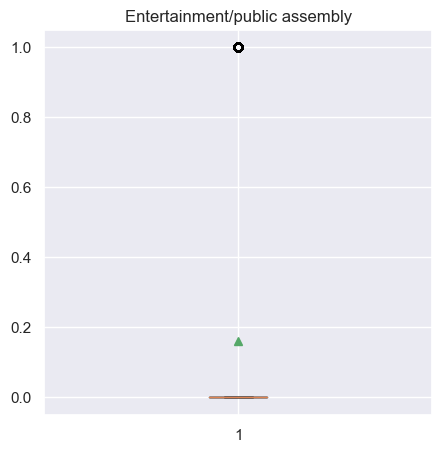

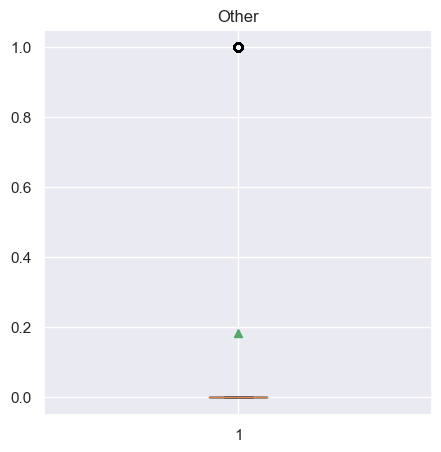

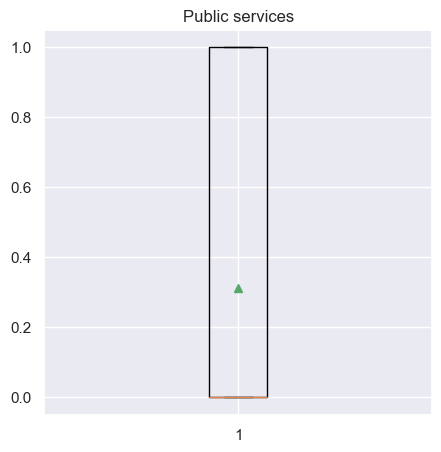

In [38]:
variables = ['meter_reading', 'sqm', 'airTemperature', 'dewTemperature','precipDepth1HR', 'seaLvlPressure', 'windDirection', 'windSpeed','Education', 'Entertainment/public assembly', 'Other','Public services']

for variable in variables:
    fig, axs = plt.subplots(figsize=(5, 5))
    axs.boxplot(features[variable], showmeans=True)
    axs.set_title(variable)
    plt.show()

### Treat outliers

In [39]:
# # Define variables to cap and floor
# vars_cap = ['meter_reading', 'sqm', 'precipDepth1HR', 'seaLvlPressure','windSpeed']

# # Cap and floor variables selected 
# features = treatoutliers(df = features, columns = vars_cap, method = 'PCT', treament = 'cap', pct_min = 0.05, pct_max = 0.95)

# ## See new result 
# variables = ['meter_reading', 'sqm', 'airTemperature', 'dewTemperature','precipDepth1HR', 'seaLvlPressure', 'windDirection', 'windSpeed','Education', 'Entertainment/public assembly', 'Other','Public services']

# for variable in variables:
#     fig, axs = plt.subplots(figsize=(5, 5))
#     axs.boxplot(features[variable], showmeans=True)
#     axs.set_title(variable)
#     plt.show()

In [40]:
df

,timestamp,year,month,meter_reading,building_id_kaggle,sqm,yearbuilt,airTemperature,dewTemperature,precipDepth1HR,seaLvlPressure,windDirection,windSpeed,Education,Entertainment/public assembly,Other,Public services
0,2016-01-01 00:00:00,2016,1,14.59,466.00,2090.30,1968,7.20,0.00,0.00,1021.50,350.00,5.10,0,0,0,1
1,2016-01-01 01:00:00,2016,1,14.67,466.00,2090.30,1968,6.70,0.00,0.00,1021.10,340.00,3.60,0,0,0,1
2,2016-01-01 02:00:00,2016,1,14.58,466.00,2090.30,1968,5.60,0.00,0.00,1020.80,350.00,3.10,0,0,0,1
3,2016-01-01 03:00:00,2016,1,14.57,466.00,2090.30,1968,5.60,0.00,0.00,1021.10,340.00,3.60,0,0,0,1
4,2016-01-01 04:00:00,2016,1,14.92,466.00,2090.30,1968,5.60,-1.10,0.00,1020.70,320.00,3.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5350915,2017-12-31 19:00:00,2017,12,34.96,478.00,2906.30,1935,-7.20,-15.00,0.00,1029.50,320.00,4.60,0,0,1,0
5350916,2017-12-31 20:00:00,2017,12,33.74,478.00,2906.30,1935,-7.20,-15.60,0.00,1030.00,310.00,4.60,0,0,1,0
5350917,2017-12-31 21:00:00,2017,12,32.42,478.00,2906.30,1935,-7.80,-15.60,0.00,1030.30,330.00,3.60,0,0,1,0
5350918,2017-12-31 22:00:00,2017,12,30.81,478.00,2906.30,1935,-8.30,-16.70,0.00,1030.40,340.00,4.60,0,0,1,0


In [41]:
df.to_csv("Final_BD.csv", index=False, encoding='utf-8')

# Load Final Dataset

In [42]:
df = pd.read_csv("Final_BD.csv", header=0, delimiter=',')
df

,timestamp,year,month,meter_reading,building_id_kaggle,sqm,yearbuilt,airTemperature,dewTemperature,precipDepth1HR,seaLvlPressure,windDirection,windSpeed,Education,Entertainment/public assembly,Other,Public services
0,2016-01-01 00:00:00,2016,1,14.59,466.00,2090.30,1968,7.20,0.00,0.00,1021.50,350.00,5.10,0,0,0,1
1,2016-01-01 01:00:00,2016,1,14.67,466.00,2090.30,1968,6.70,0.00,0.00,1021.10,340.00,3.60,0,0,0,1
2,2016-01-01 02:00:00,2016,1,14.58,466.00,2090.30,1968,5.60,0.00,0.00,1020.80,350.00,3.10,0,0,0,1
3,2016-01-01 03:00:00,2016,1,14.57,466.00,2090.30,1968,5.60,0.00,0.00,1021.10,340.00,3.60,0,0,0,1
4,2016-01-01 04:00:00,2016,1,14.92,466.00,2090.30,1968,5.60,-1.10,0.00,1020.70,320.00,3.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4907187,2017-12-31 19:00:00,2017,12,34.96,478.00,2906.30,1935,-7.20,-15.00,0.00,1029.50,320.00,4.60,0,0,1,0
4907188,2017-12-31 20:00:00,2017,12,33.74,478.00,2906.30,1935,-7.20,-15.60,0.00,1030.00,310.00,4.60,0,0,1,0
4907189,2017-12-31 21:00:00,2017,12,32.42,478.00,2906.30,1935,-7.80,-15.60,0.00,1030.30,330.00,3.60,0,0,1,0
4907190,2017-12-31 22:00:00,2017,12,30.81,478.00,2906.30,1935,-8.30,-16.70,0.00,1030.40,340.00,4.60,0,0,1,0


In [43]:
#Create variable for age 

df['building_age'] = df['year'] - df['yearbuilt']
df

,timestamp,year,month,meter_reading,building_id_kaggle,sqm,yearbuilt,airTemperature,dewTemperature,precipDepth1HR,seaLvlPressure,windDirection,windSpeed,Education,Entertainment/public assembly,Other,Public services,building_age
0,2016-01-01 00:00:00,2016,1,14.59,466.00,2090.30,1968,7.20,0.00,0.00,1021.50,350.00,5.10,0,0,0,1,48
1,2016-01-01 01:00:00,2016,1,14.67,466.00,2090.30,1968,6.70,0.00,0.00,1021.10,340.00,3.60,0,0,0,1,48
2,2016-01-01 02:00:00,2016,1,14.58,466.00,2090.30,1968,5.60,0.00,0.00,1020.80,350.00,3.10,0,0,0,1,48
3,2016-01-01 03:00:00,2016,1,14.57,466.00,2090.30,1968,5.60,0.00,0.00,1021.10,340.00,3.60,0,0,0,1,48
4,2016-01-01 04:00:00,2016,1,14.92,466.00,2090.30,1968,5.60,-1.10,0.00,1020.70,320.00,3.10,0,0,0,1,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4907187,2017-12-31 19:00:00,2017,12,34.96,478.00,2906.30,1935,-7.20,-15.00,0.00,1029.50,320.00,4.60,0,0,1,0,82
4907188,2017-12-31 20:00:00,2017,12,33.74,478.00,2906.30,1935,-7.20,-15.60,0.00,1030.00,310.00,4.60,0,0,1,0,82
4907189,2017-12-31 21:00:00,2017,12,32.42,478.00,2906.30,1935,-7.80,-15.60,0.00,1030.30,330.00,3.60,0,0,1,0,82
4907190,2017-12-31 22:00:00,2017,12,30.81,478.00,2906.30,1935,-8.30,-16.70,0.00,1030.40,340.00,4.60,0,0,1,0,82


# EDA - Final Dataset

## Relationship with target variable

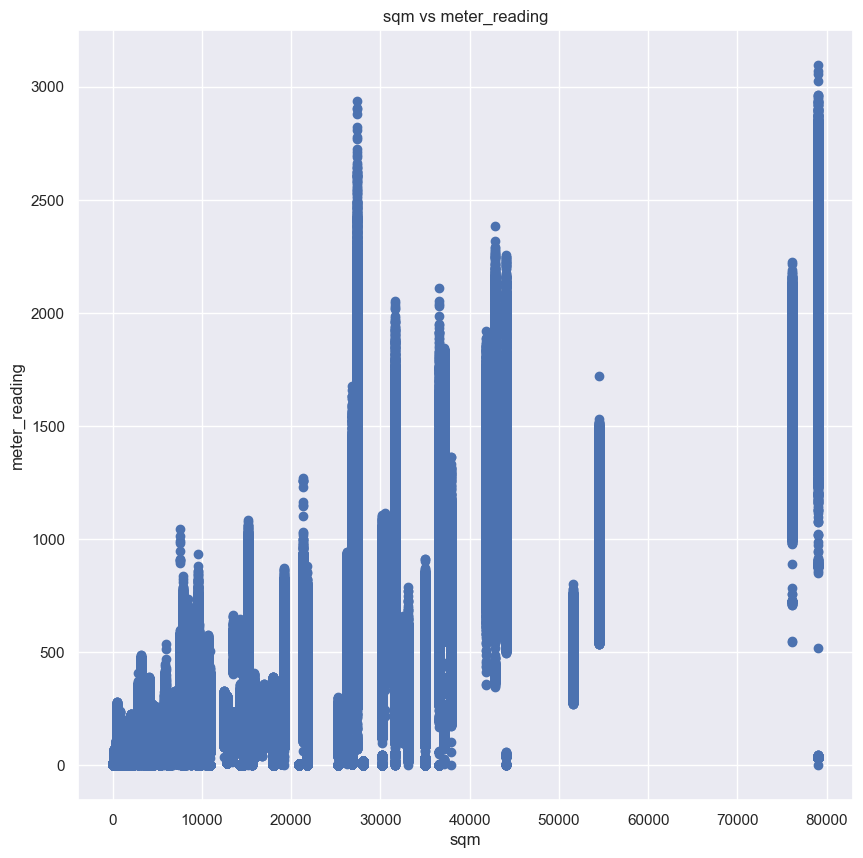

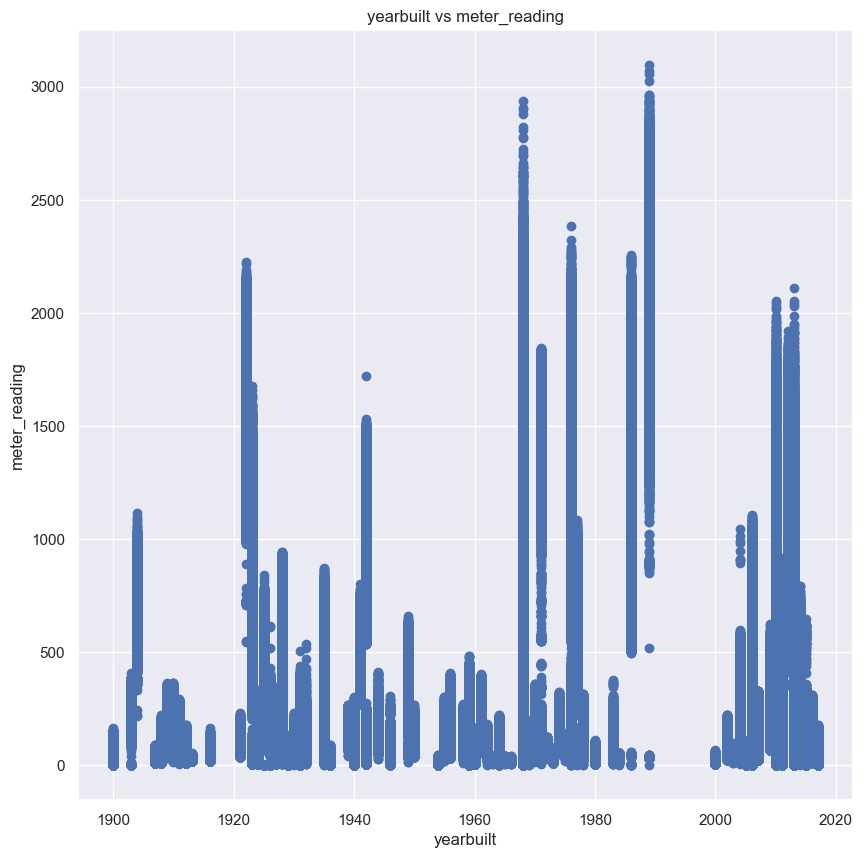

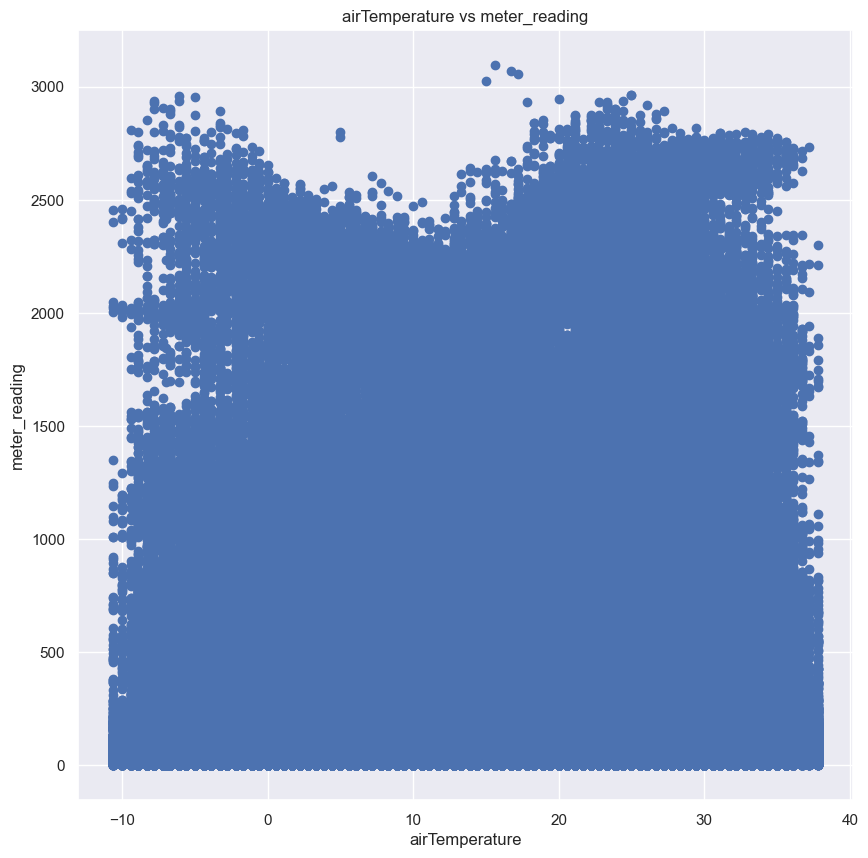

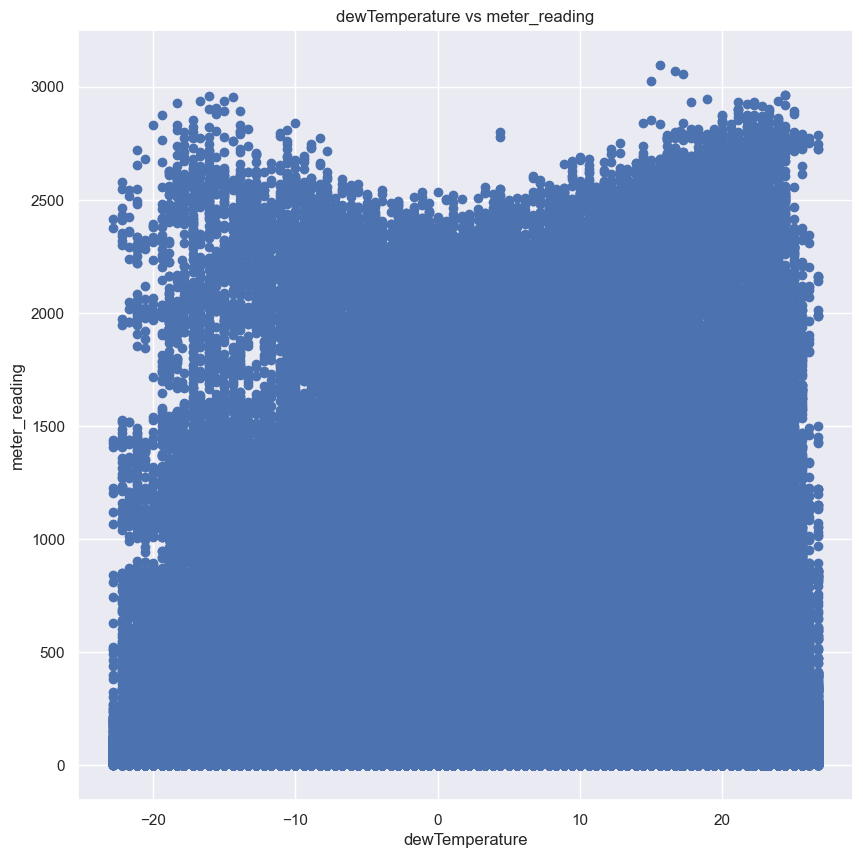

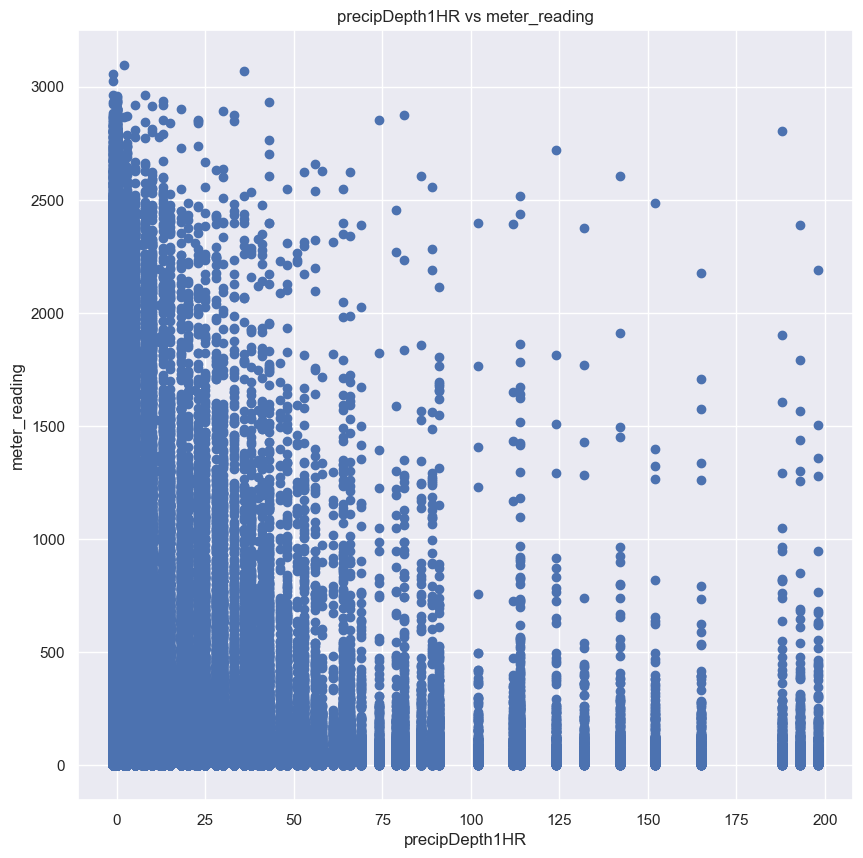

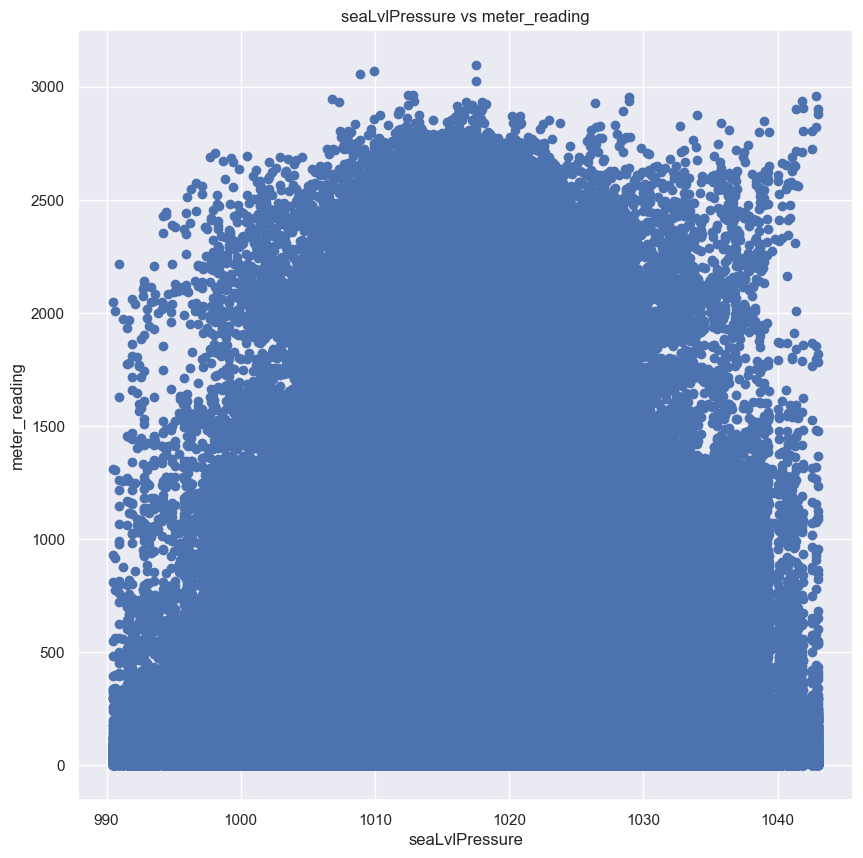

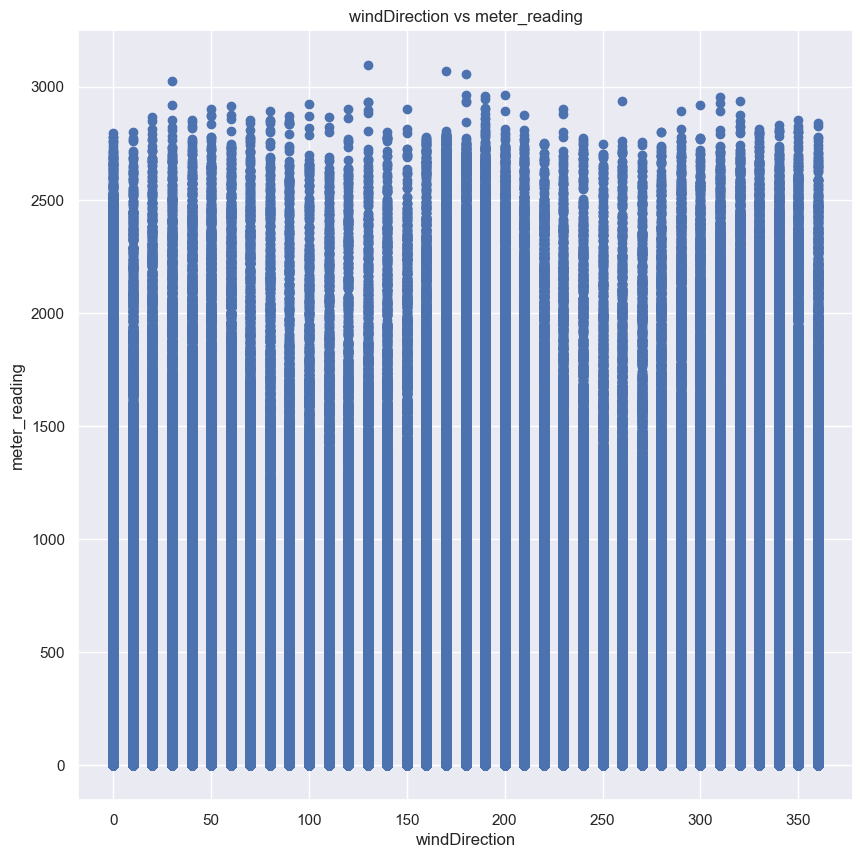

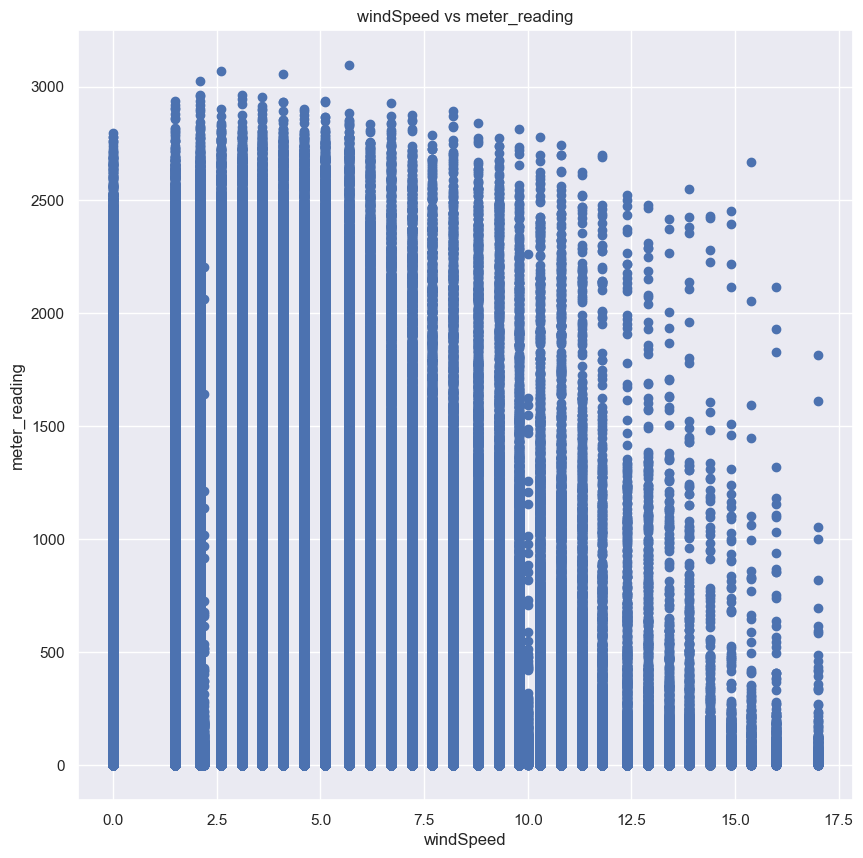

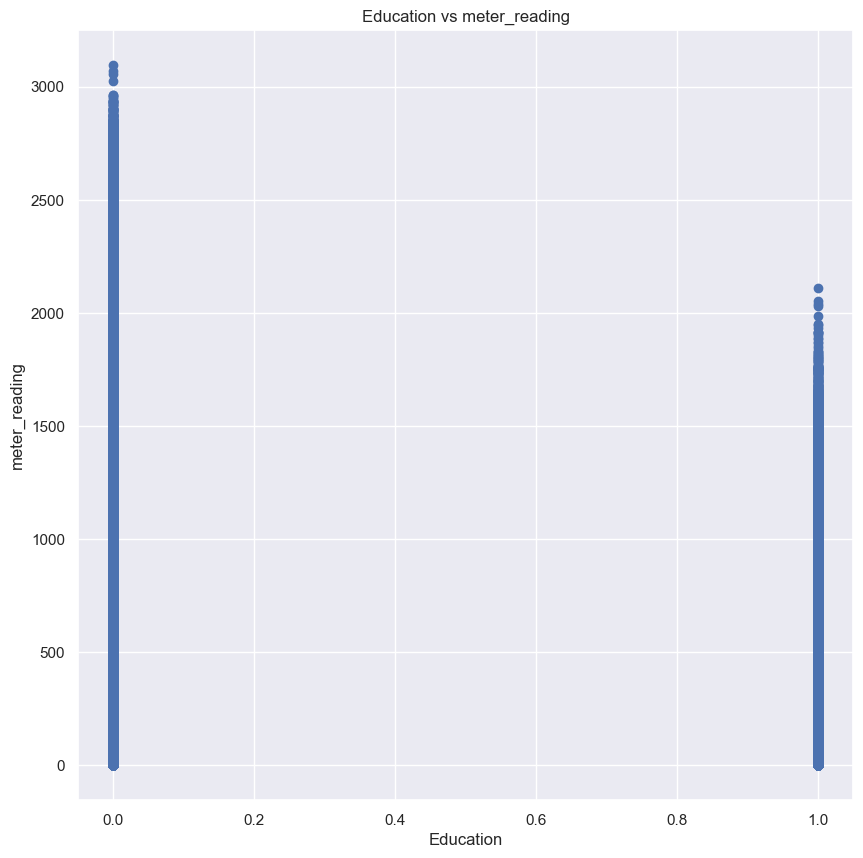

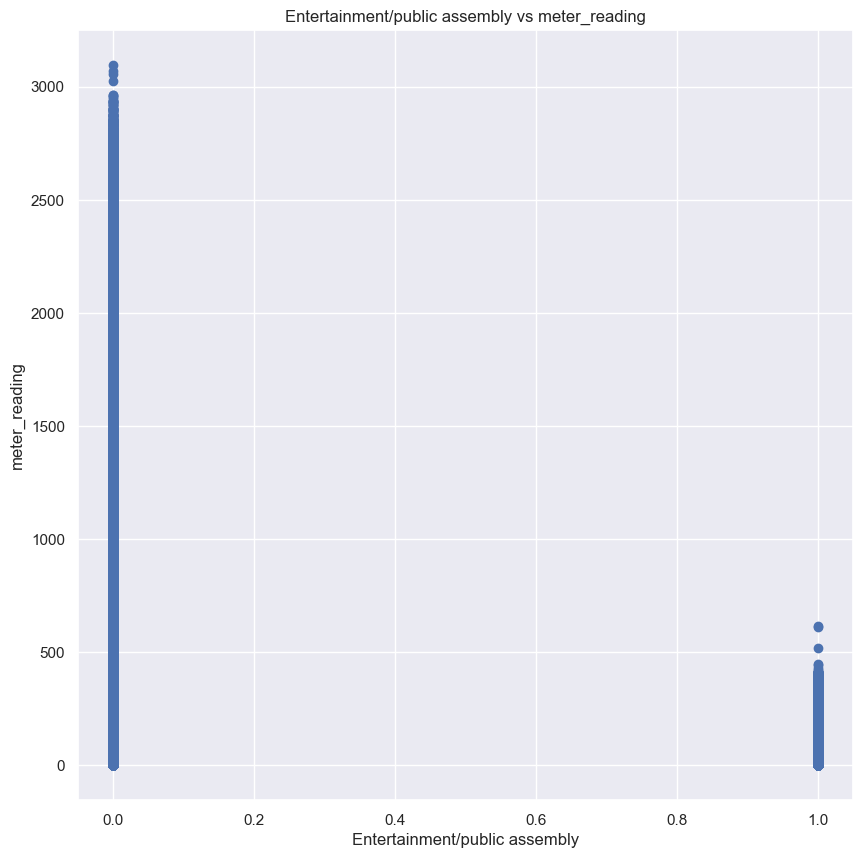

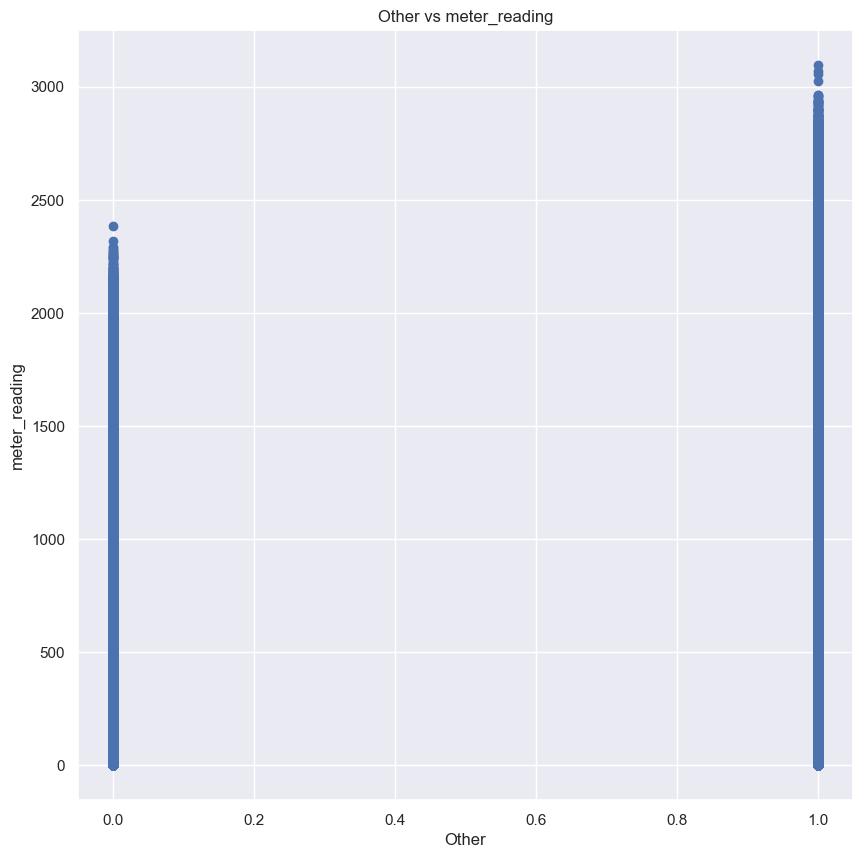

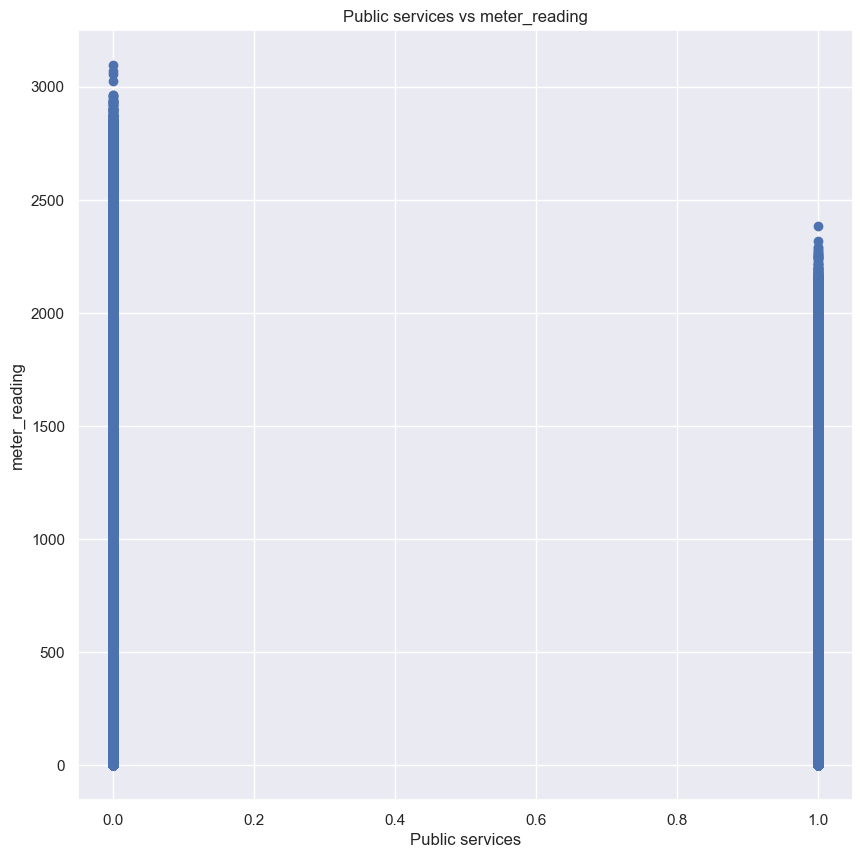

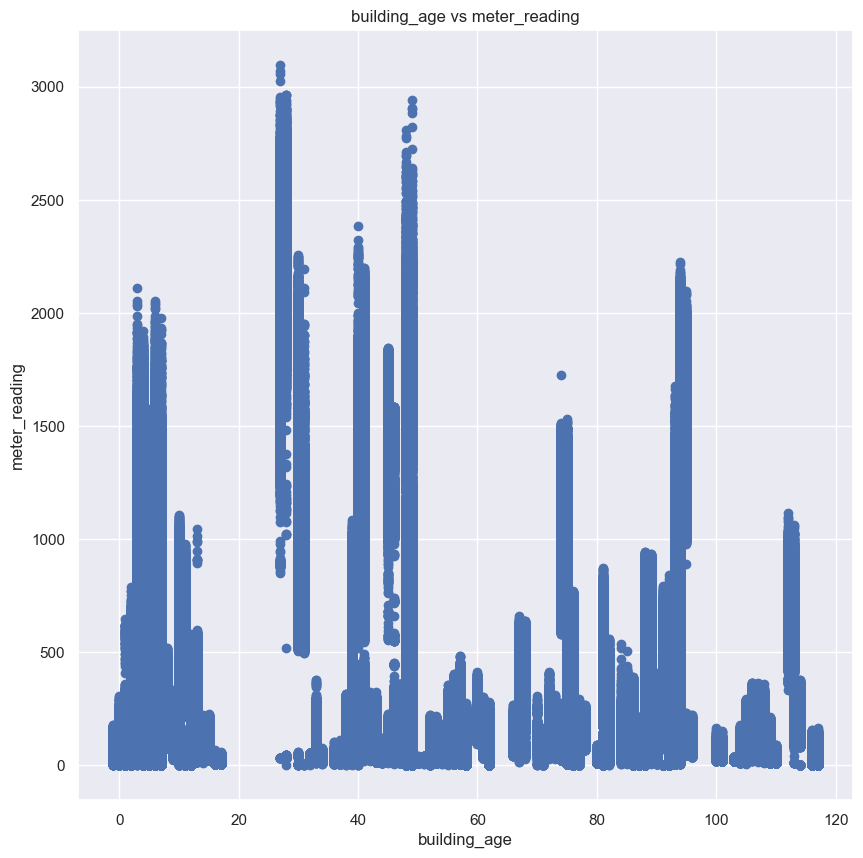

In [44]:
# create a list of variables to plot against meter_reading
variables = ['sqm', 'yearbuilt', 'airTemperature', 'dewTemperature', 
             'precipDepth1HR', 'seaLvlPressure', 'windDirection', 'windSpeed', 
             'Education', 'Entertainment/public assembly', 'Other', 
             'Public services', 'building_age']

# create a scatter plot for each variable against meter_reading
for var in variables:
    plt.scatter(df[var], df['meter_reading'])
    plt.title(f'{var} vs meter_reading')
    plt.xlabel(var)
    plt.ylabel('meter_reading')
    plt.show()

## Full data profiling

In [45]:
profile = ProfileReport(df, title="Profiling Report", html = {'style':{'primary_color': "#000000"}})
profile.to_file("DataProfile_Elecricity.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Modeling 

<em><strong>==========================================================================================</strong></em>.

Now that we have cleaned and preprocessed the data, our focus turns to modeling. Specifically, we performed several supervised models to predict energy consumption and establish the importance of various features. Specifically, we used `multiple linear regression, decision tree, XG boost, and random forest models` to analyze the data.

To train our models, we used the observations from 2016 and tested them on the observations from 2017. Through this process, we aimed to develop models that could accurately predict energy consumption and provide recommendations based on our findings. Our goal was to identify the key factors that influence energy consumption and provide insights that could help you make informed decisions about energy management.

<em><strong>==========================================================================================</strong></em>.

## PCA

In [46]:
# BOLD = '\033[1m'
# RESET = '\033[0m'

# X = df.iloc[:, [3, 5,7,8,9,10,11,12,13,14,15,16]]
# X 

# # Standardize Data
# XT= StandardScaler().fit_transform(X)

# # Define PCA
# pca = PCA()

# X_fit_pca = pca.fit_transform(XT)
# explained_variance = pca.explained_variance_ratio_
# pd.DataFrame(explained_variance, columns= ['exp_var'])
# pd.DataFrame(explained_variance, columns= ['exp_var']).plot.line(color = "#00cfcc")

# # Define PC
# PC = 4
# pca = PCA(n_components = PC)

# features_pca = pd.DataFrame(pca.fit_transform(XT), columns = ['c{}'.format(i) for i in range(1, PC+1)])
# explained_variance = pca.explained_variance_ratio_

# # Print explained variance per component
# for i in range(PC):
#     print(f"Explained variance of PC{i+1}: {explained_variance[i]:.4f}")
    
# print("======================================================================================================")
# print(f"The explained variance is {BOLD}{round(np.sum(explained_variance),4)}{RESET} with {BOLD}{PC}{RESET} Principal Components")
# print("======================================================================================================")

##  Split train and test 

In [47]:
# Divide data in train /test randomly, taking the train the observation in 2016

# Train set

x_train = df[df.timestamp < "2017-01-01"].set_index("timestamp").drop(labels=['meter_reading', 'building_id_kaggle','year', 'month'], axis=1)
y_train = df[df.timestamp < "2017-01-01"].set_index("timestamp").meter_reading

# test set
x_test = df[df.timestamp >= "2017-01-01"].set_index("timestamp").drop(labels=['meter_reading', 'building_id_kaggle','year', 'month'], axis=1)
y_test =df[df.timestamp >= "2017-01-01"].set_index("timestamp").meter_reading


print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

random_seed = 1234
random_state = random_seed

X Train shape: (2557051, 13)
Y Train shape: (2557051,)
X Test shape: (2350141, 13)
Y Test shape: (2350141,)


## Multiple Linear regression

In [48]:
x_train_glob = x_train
x_test_glob = x_test

In [49]:
# Select the explanatory variables to be used
#vars_select = ['sqm', 'yearbuilt', 'airTemperature', 'dewTemperature','precipDepth1HR', 'seaLvlPressure', 'windDirection', 'windSpeed','Education', 'Entertainment/public assembly','Public services']
vars_select = ['sqm', 'building_age', 'airTemperature','Education', 'Entertainment/public assembly','Public services']

In [50]:
x_train = x_train_glob.loc[:, x_train_glob.columns.isin(vars_select)].copy()
x_test = x_test_glob.loc[:, x_test_glob.columns.isin(vars_select)].copy()

# Add a column full of 1 to estimate the intercept parameter 
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

# Define model
model = sm.OLS(y_train, x_train)
# Fit model
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          meter_reading   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                 9.842e+05
Date:                Wed, 19 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:39:12   Log-Likelihood:            -1.6237e+07
No. Observations:             2557051   AIC:                         3.247e+07
Df Residuals:                 2557044   BIC:                         3.247e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [51]:
# Checking assumptions
# Multicolinearity
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
aux = x_train.drop(['const'],axis=1)
# aux = x_train.copy()
vif["VIF Factor"] = [variance_inflation_factor(aux.values, i) for i in range(aux.shape[1])]
vif["features"] = aux.columns
print("======================================================================================")
print("Multicolinarity check using VIF:")
print(vif.sort_values('VIF Factor',ascending=False).round(1))

# Get residuals
residuals = results.resid

# Independence of errors
print("======================================================================================")
print("Independence of errors check using Durbin-Watson test:")
dw_stats = sm.stats.stattools.durbin_watson(residuals, axis=0)
print("D-W statistic:", dw_stats)
if dw_stats <= 2.5 and dw_stats >= 1.5:
  print("Residuals are independent")
else:
  print("Residuals are NOT independent")

# Homocedasticity
fvalue, f_pvalue, ordering = sm.stats.diagnostic.het_goldfeldquandt(y_train, x_train)
print("======================================================================================")
print("Homocedasticity check using Goldfeld-Quandt test:")
print("F-value",fvalue,"P-value", f_pvalue)

print("======================================================================================")
# Predict values of regression with train
ypred_train = results.predict(x_train)
# Predict values of regression with test
ypred_test = results.predict(x_test)

print("Evaluating results of the regression:")
print("RMSE Score for train, test: {}, {}".format(rmse(y_train, ypred_train), rmse(y_test, ypred_test)))
print("R2 for train, test: {}, {}".format(r2_score(y_train, ypred_train), r2_score(y_test, ypred_test)))

Multicolinarity check using VIF:
   VIF Factor                       features
5        4.00                   building_age
1        2.70                 airTemperature
2        2.50                      Education
4        2.00                Public services
3        1.50  Entertainment/public assembly
0        1.40                            sqm
Independence of errors check using Durbin-Watson test:
D-W statistic: 0.02919745248180617
Residuals are NOT independent
Homocedasticity check using Goldfeld-Quandt test:
F-value 1.2093309719573417 P-value 0.0
Evaluating results of the regression:
RMSE Score for train, test: 138.5107424410956, 132.37017578293967
R2 for train, test: 0.697834442481899, 0.669090878475106


## Decision Tree

In [52]:
from sklearn.tree import DecisionTreeRegressor

# Add a column full of 1 to estimate the intercept parameter 
# x_train = sm.add_constant(x_train)
# x_test = sm.add_constant(x_test)

vars_select = ['sqm', 'building_age', 'airTemperature','Education', 'Entertainment/public assembly','Public services']


x_train = x_train_glob.loc[:, x_train_glob.columns.isin(vars_select)].copy()
x_test = x_test_glob.loc[:, x_test_glob.columns.isin(vars_select)].copy()

# create decision tree regressor and fit to training data
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(x_train, y_train)

# Predict values of regression with train
ypred_train = dt_regressor.predict(x_train)
# Predict values of regression with test
ypred_test = dt_regressor.predict(x_test)

# Calculate root mean squared error

print("Evaluating results of the regression:")
print("RMSE Score for train, test: {}, {}".format(rmse(y_train, ypred_train), rmse(y_test, ypred_test)))
print("R2 for train, test: {}, {}".format(r2_score(y_train, ypred_train), r2_score(y_test, ypred_test)))

Evaluating results of the regression:
RMSE Score for train, test: 70.48503050657062, 99.0566954755582
R2 for train, test: 0.9217522552287276, 0.814691167789046


In [53]:
x_train_s = x_train.sample(frac=0.01)
x_test_s = x_test.sample(frac=0.01)

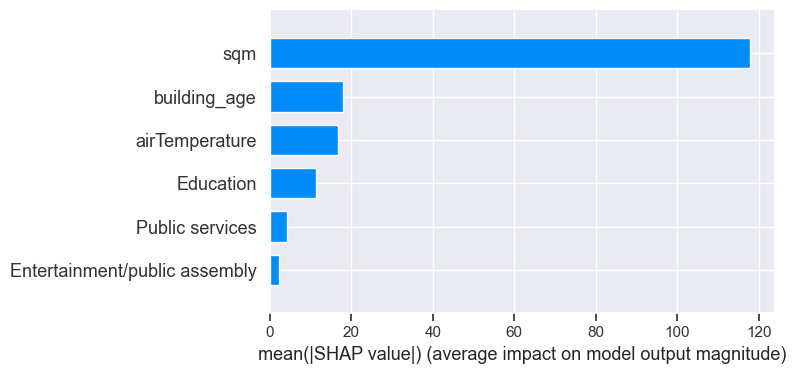

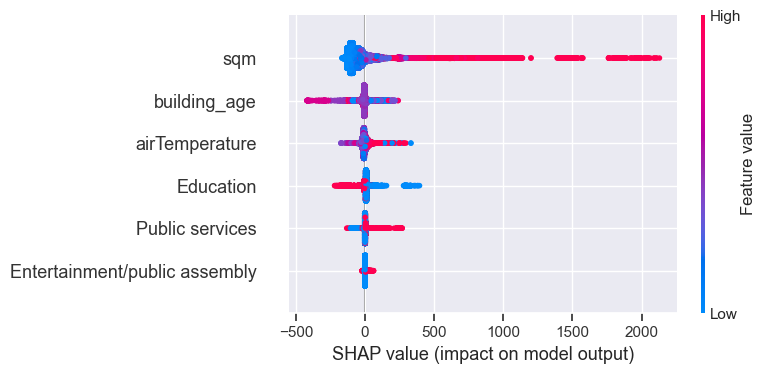

In [54]:
shap_values = shap.TreeExplainer(dt_regressor).shap_values(x_train_s)
shap.summary_plot(shap_values, x_train_s, plot_type="bar")

dt_shap_values = shap_values
shap.summary_plot(dt_shap_values, x_train_s)

## XG-boost 

In [55]:
# Define variables to select for the model
vars_select = ['sqm', 'building_age', 'airTemperature','Education', 'Entertainment/public assembly','Public services']

# Create train and test datasets based on the selected variables
x_train = x_train_glob.loc[:, vars_select].copy()
x_test = x_test_glob.loc[:, vars_select].copy()

# Initialize the XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, random_state=42)

# Train the XGBoost regressor
xgb_reg.fit(x_train, y_train)

# Predict values of regression with train
ypred_train = xgb_reg.predict(x_train)
# Predict values of regression with test
ypred_test = xgb_reg.predict(x_test)

# Calculate root mean squared error and R2 score
print("Evaluating results of the regression:")
print("RMSE Score for train, test: {}, {}".format(mean_squared_error(y_train, ypred_train, squared=False), mean_squared_error(y_test, ypred_test, squared=False)))
print("R2 for train, test: {}, {}".format(r2_score(y_train, ypred_train), r2_score(y_test, ypred_test)))

Evaluating results of the regression:
RMSE Score for train, test: 80.86940054829684, 96.60453251838628
R2 for train, test: 0.8969978018548767, 0.8237523017265387


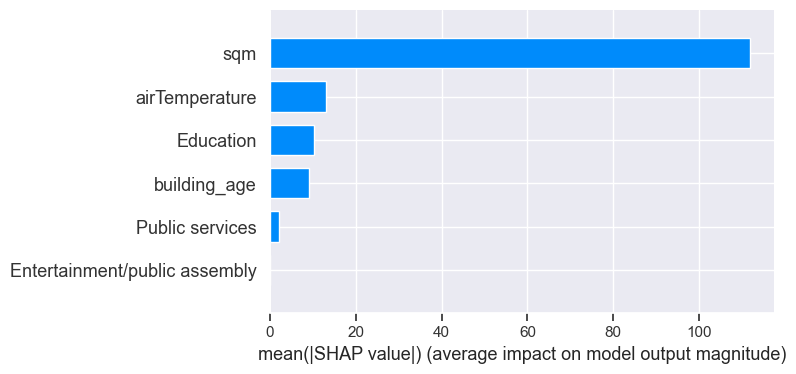

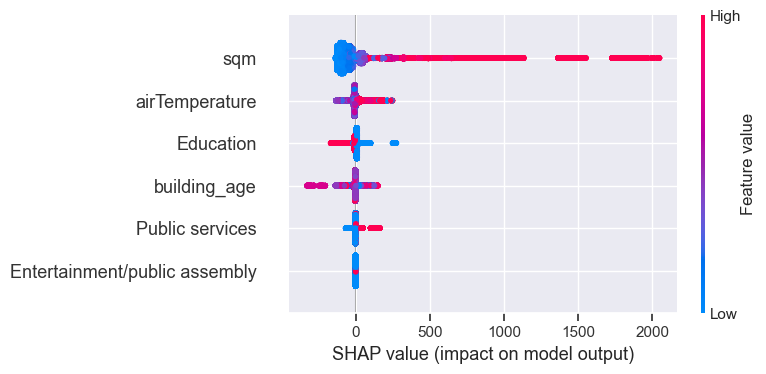

In [56]:
x_train_s = x_train.sample(frac=0.05)
x_test_s = x_test.sample(frac=0.05)

shap_values = shap.TreeExplainer(xgb_reg).shap_values(x_train_s)
shap.summary_plot(shap_values, x_train_s, plot_type="bar")

f = plt.figure()
rf_shap_values = shap_values
shap.summary_plot(rf_shap_values, x_train_s)
#f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

## Random Forest

In [57]:
# # Add a column full of 1 to estimate the intercept parameter 
# x_train = sm.add_constant(x_train)
# x_test = sm.add_constant(x_test)

vars_select = ['sqm', 'building_age', 'airTemperature','Education', 'Entertainment/public assembly','Public services']

x_train = x_train_glob.loc[:, x_train_glob.columns.isin(vars_select)].copy()
x_test = x_test_glob.loc[:, x_test_glob.columns.isin(vars_select)].copy()

# Initialize the random forest regressor
rf_reg = RandomForestRegressor(n_estimators=10, random_state=42)

# Train the random forest regressor
rf_reg.fit(x_train, y_train)

# Predict values of regression with train
ypred_train = rf_reg.predict(x_train)
# Predict values of regression with test
ypred_test = rf_reg.predict(x_test)

# Calculate root mean squared error

print("Evaluating results of the regression:")
print("RMSE Score for train, test: {}, {}".format(rmse(y_train, ypred_train), rmse(y_test, ypred_test)))
print("R2 for train, test: {}, {}".format(r2_score(y_train, ypred_train), r2_score(y_test, ypred_test)))

# Create a RandomForestClassifier object with n_estimators=100 (you can change this value as per your requirements)

# Extract feature importance
feature_importance = rf_reg.feature_importances_

# Create a DataFrame with feature names and their importance values as percentages
features_df_poc = pd.DataFrame({'Feature': x_train.columns, 'Importance': (feature_importance*100).round(2)})

# Sort the DataFrame by feature importance values in descending order
features_df_poc = features_df_poc.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
features_df_poc

Evaluating results of the regression:
RMSE Score for train, test: 70.52126918141595, 98.9974646399747
R2 for train, test: 0.9216717750616332, 0.8149127119335965


,Feature,Importance
0,sqm,88.66
5,building_age,4.88
1,airTemperature,2.96
2,Education,2.32
4,Public services,1.12
3,Entertainment/public assembly,0.06


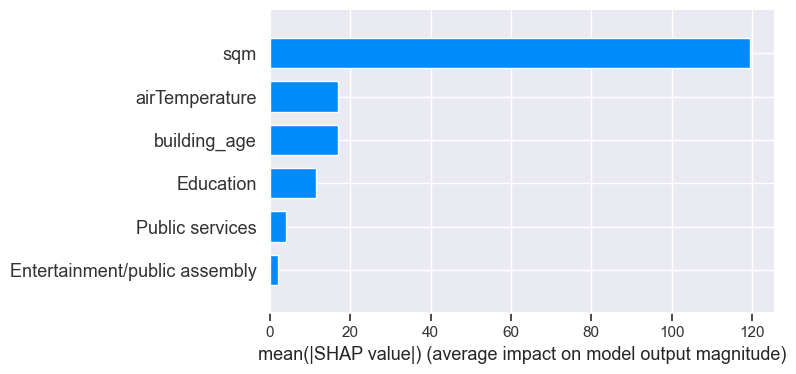

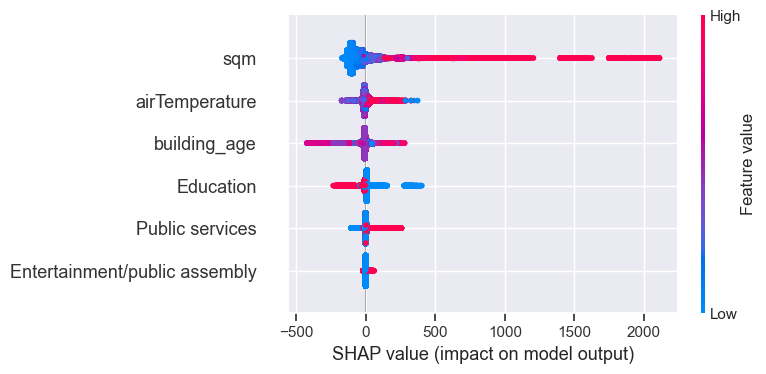

In [58]:
x_train_s = x_train.sample(frac=0.05)
x_test_s = x_test.sample(frac=0.05)

shap_values = shap.TreeExplainer(rf_reg).shap_values(x_train_s)
shap.summary_plot(shap_values, x_train_s, plot_type="bar")

f = plt.figure()
rf_shap_values = shap_values
shap.summary_plot(rf_shap_values, x_train_s)
#f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)